In [1]:
import os
import numpy as np
import glob
from tqdm import tqdm
import copy
from skimage.feature import canny
from skimage.transform import resize
import pandas as pd
import seaborn as sns
import nibabel as nib

# from torchinfo import summary

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchio as tio
import networks_gan
import losses
from skimage.metrics import structural_similarity as ssim
from dataloader import RadOncTrainingDataset, RadOncValidationDataset, RadOncSynthesisDataset, headscanner_training_dataset, headscanner_validation_dataset
import surface_distance
from helpers import compute_surface_metrics, compute_TRE
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm  # nopep8

import matplotlib.pyplot as plt
from matplotlib import colors as mplcolors
from matplotlib.collections import LineCollection
def colormap_binary(fg, bg=(0,0,0), alpha=None):
    fg = mplcolors.to_rgb(fg)
    bg = mplcolors.to_rgb(bg)
    cmap = mplcolors.LinearSegmentedColormap.from_list('Binary', (bg,fg), 256)
    if alpha is not None:
        cmap._init()
        cmap._lut[:,-1] = np.linspace(0, alpha, cmap.N+3)
    return cmap
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('dark_background')

2023-12-04 15:37:30.364695: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 15:37:30.502794: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-04 15:37:30.505983: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-04 15:37:30.505997: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [12]:
valid_dataset = RadOncValidationDataset("/mnt/blackhole-data2/RadOnc_Brain/Validation", num_samples=None, supervision=True,uncert = True,
                                            return_segmentation=True)
device = torch.device('cpu')

In [2]:
valid_dataset = RadOncValidationDataset("/home/myi16/jsr_Y/md4_val", num_samples=None, supervision=True,uncert = True,
                                            return_segmentation=True)

device = torch.device('cpu')


In [12]:
find_mr = RadOncSynthesisDataset("/home/myi16/jsr_Y/second_data")

In [6]:
G = networks_gan.JSRCascade(separate_decoders=True, res=True, version='v4').to(device)
checkpoint = torch.load('JSREDL_all_max_sup_l1100_unc0.1_inunc1_multi0.3_reg100_seg6_ep59.pt', map_location=torch.device('cpu'))
G.load_state_dict(checkpoint['G_state_dict'])

<All keys matched successfully>

In [17]:
from scipy.signal import correlate
from scipy.stats import entropy
import losses

def normalized_cross_correlation_3d(volume1, volume2):
    # Calculate the mean values
    mean1 = np.mean(volume1)
    mean2 = np.mean(volume2)

    # Calculate cross-correlation in 3D
    cross_corr = correlate(volume1 - mean1, volume2 - mean2, mode='same')

    # Calculate standard deviations
    std1 = np.std(volume1)
    std2 = np.std(volume2)

    # Calculate NCC for 3D volumes
    ncc = cross_corr / (std1 * std2 * volume1.size)+1e-6

    return ncc

def mutual_information_3d(volume1, volume2, bins=256):
    # Flatten the volumes
    hist_3d, x_edges, y_edges = np.histogram2d(
        volume1.ravel(), volume2.ravel(), bins=bins)

    # Calculate entropy of the joint histogram
    pxy = hist_3d / float(np.sum(hist_3d))
    hxy = entropy(pxy)

    # Calculate entropies of the individual histograms
    px = np.histogram(volume1, bins=bins)[0] / float(volume1.size)
    py = np.histogram(volume2, bins=bins)[0] / float(volume2.size)
    hx = entropy(px)
    hy = entropy(py)

    # Calculate mutual information for 3D volumes
    mi = hx + hy - hxy

    return mi

for i in tqdm(range(9,10)):
    data = valid_dataset[i]
    cbct_fixed = data[0].to(device).to(device)
    mr_moving = data[1].to(device).to(device)
    ct_fixed = data[2].to(device)
    ct_moving = data[3].to(device)
    gt = torch.from_numpy(data[-1]).to(device)
    with torch.no_grad():
        flows,_, _ = G(mr_moving, cbct_fixed)
        mr_reg = vxm.layers.SpatialTransformer([128,160,128], mode='bilinear').to(device)(mr_moving, flows[0])
        uncert = flows[4]
        alpha_x = uncert[0,0,:,:,:]+1
        beta_x = uncert[0,1,:,:,:]
        mu_x = uncert[0,2,:,:,:]
        omega_x = 2*beta_x*(1+mu_x)
        alpha_y = uncert[0,3,:,:,:]+1
        beta_y = uncert[0,4,:,:,:]
        mu_y = uncert[0,5,:,:,:]
        omega_y = 2*beta_y*(1+mu_y)
        alpha_z = uncert[0,6,:,:,:]+1
        beta_z = uncert[0,7,:,:,:]
        mu_z = uncert[0,8,:,:,:]
        omega_z = 2*beta_z*(1+mu_z)    
    alea_x = beta_x/(alpha_x-1+1e-6)
    alea_y = beta_y/(alpha_y-1+1e-6)
    alea_z = beta_z/(alpha_z-1+1e-6)

    epi_x = beta_x/(mu_x*(alpha_x-1)+1e-6)
    epi_y = beta_y/(mu_y*(alpha_y-1)+1e-6)
    epi_z = beta_z/(mu_z*(alpha_z-1)+1e-6)
    plt.style.use('dark_background')
    islice = 72

    
    mask_head = (cbct_fixed[0,0,:,:,:].cpu().numpy()>0.05).astype(int)
    alx = (alea_x.cpu().numpy()*mask_head).T
    aly = (alea_y.cpu().numpy()*mask_head).T
    alz = (alea_z.cpu().numpy()*mask_head).T
    
    ex = (epi_x.cpu().numpy()*mask_head).T
    ey = (epi_y.cpu().numpy()*mask_head).T
    ez = (epi_z.cpu().numpy()*mask_head).T
    
    pred = flows[0]**2
    error = (pred+gt)**2
    
    predx = (pred[0,0,:,:,:].numpy()*mask_head).T
    predy = (pred[0,1,:,:,:].numpy()*mask_head).T
    predz = (pred[0,2,:,:,:].numpy()*mask_head).T
    
    errorx = (error[0,0,:,:,:].numpy()*mask_head).T
    errory = (error[0,1,:,:,:].numpy()*mask_head).T
    errorz = (error[0,2,:,:,:].numpy()*mask_head).T
    
    print('NCC between alea and pred:')
    print(normalized_cross_correlation_3d(predx, alx).mean(),normalized_cross_correlation_3d(predy, aly).mean(),normalized_cross_correlation_3d(predz, alz).mean())
    print('NCC between alea and error:')
    print(normalized_cross_correlation_3d(errorx, alx).mean(),normalized_cross_correlation_3d(errory, aly).mean(),normalized_cross_correlation_3d(errorz, alz).mean())
    print('NCC between epis and pred:')
    print(normalized_cross_correlation_3d(predx, ex).mean(),normalized_cross_correlation_3d(predy, ey).mean(),normalized_cross_correlation_3d(predz, ez).mean())
    print('NCC between alea and error:')
    print(normalized_cross_correlation_3d(errorx, ex).mean(),normalized_cross_correlation_3d(errory, ey).mean(),normalized_cross_correlation_3d(errorz, ez).mean())
    
    # print('MI between epis and pred:')
    # print(mutual_information_3d(predx, alx).mean(),mutual_information_3d(predy, aly).mean(),mutual_information_3d(predz, alz).mean())
    # print('MI between alea and error:')
    # print(mutual_information_3d(errorx, alx).mean(),mutual_information_3d(errory, aly).mean(),mutual_information_3d(errorz, alz).mean())
    # print('MI between epis and pred:')
    # print(mutual_information_3d(predx, ex).mean(),mutual_information_3d(predy, ey).mean(),mutual_information_3d(predz, ez).mean())
    # print('MI between alea and error:')
    # print(mutual_information_3d(errorx, ex).mean(),mutual_information_3d(errory, ey).mean(),mutual_information_3d(errorz, ez).mean())


  0%|          | 0/1 [00:00<?, ?it/s]

NCC between alea and pred:
0.010600730751047126 0.0009105389257274344 0.0005370004606797952
NCC between alea and error:
0.005529408042261986 0.0002780391787426342 0.000374544322042336
NCC between epis and pred:
0.0028259955579412748 0.0016032677719914953 0.00010826932879923995
NCC between alea and error:


100%|██████████| 1/1 [00:22<00:00, 22.04s/it]

0.0017196208414938965 0.000557150066992301 6.330498790305776e-05


  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_23370/1514950862.py:38: RuntimeWarning: invalid value encountered in multiply
  alx = (alea_x.cpu().numpy()[:,:,islice]*mask_head).T
/tmp/ipykernel_23370/1514950862.py:39: RuntimeWarning: invalid value encountered in multiply
  aly = (alea_y.cpu().numpy()[:,:,islice]*mask_head).T
/tmp/ipykernel_23370/1514950862.py:42: RuntimeWarning: invalid value encountered in multiply
  ex = (epi_x.cpu().numpy()[:,:,islice]*mask_head).T
/tmp/ipykernel_23370/1514950862.py:43: RuntimeWarning: invalid value encountered in multiply
  ey = (epi_y.cpu().numpy()[:,:,islice]*mask_head).T


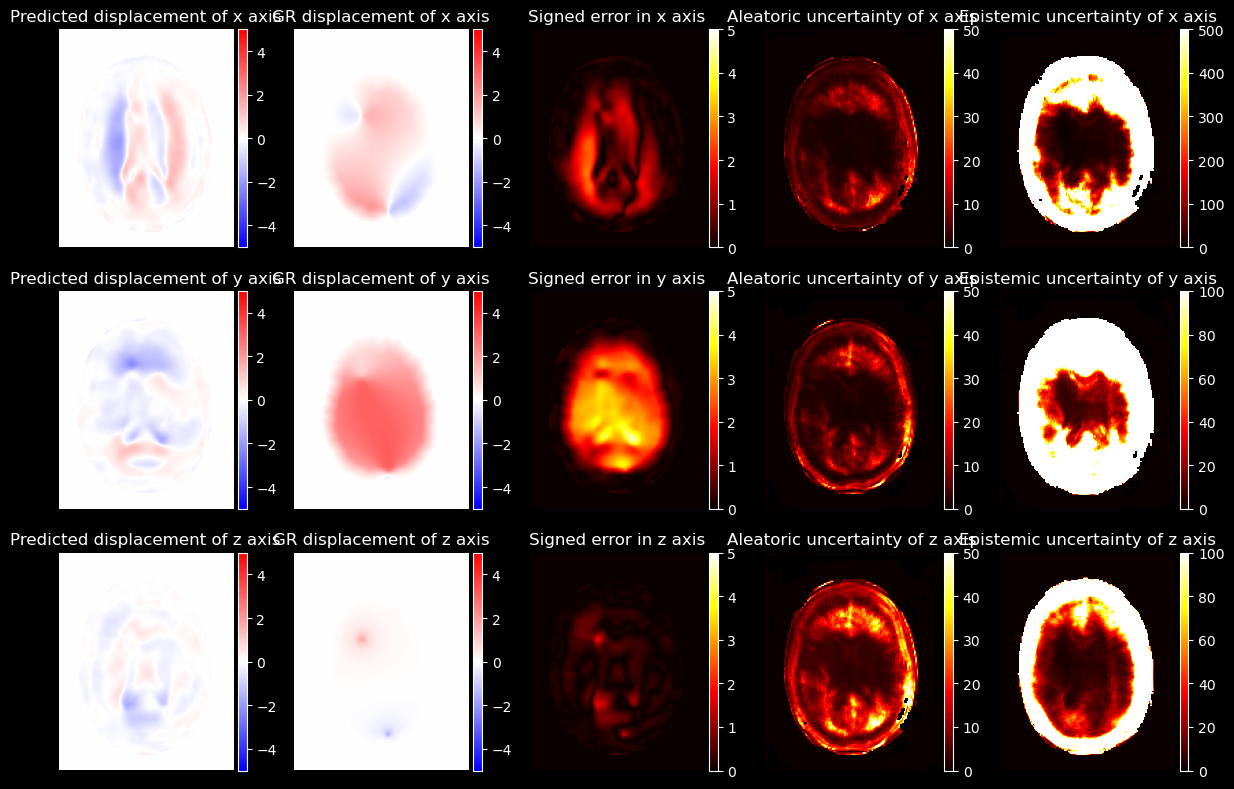

 10%|█         | 1/10 [00:10<01:32, 10.29s/it]/tmp/ipykernel_23370/1514950862.py:38: RuntimeWarning: invalid value encountered in multiply
  alx = (alea_x.cpu().numpy()[:,:,islice]*mask_head).T
/tmp/ipykernel_23370/1514950862.py:39: RuntimeWarning: invalid value encountered in multiply
  aly = (alea_y.cpu().numpy()[:,:,islice]*mask_head).T
/tmp/ipykernel_23370/1514950862.py:42: RuntimeWarning: invalid value encountered in multiply
  ex = (epi_x.cpu().numpy()[:,:,islice]*mask_head).T
/tmp/ipykernel_23370/1514950862.py:43: RuntimeWarning: invalid value encountered in multiply
  ey = (epi_y.cpu().numpy()[:,:,islice]*mask_head).T


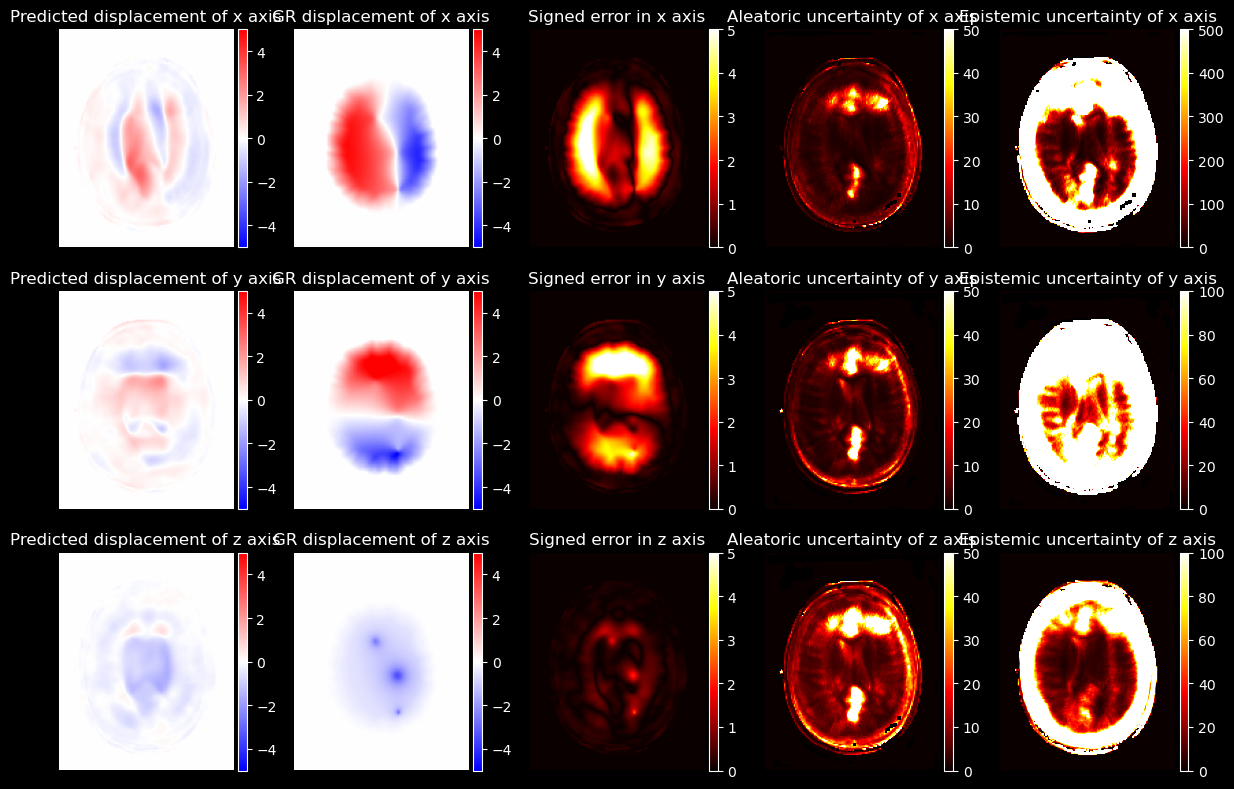

 20%|██        | 2/10 [00:21<01:26, 10.76s/it]/tmp/ipykernel_23370/1514950862.py:38: RuntimeWarning: invalid value encountered in multiply
  alx = (alea_x.cpu().numpy()[:,:,islice]*mask_head).T
/tmp/ipykernel_23370/1514950862.py:39: RuntimeWarning: invalid value encountered in multiply
  aly = (alea_y.cpu().numpy()[:,:,islice]*mask_head).T
/tmp/ipykernel_23370/1514950862.py:42: RuntimeWarning: invalid value encountered in multiply
  ex = (epi_x.cpu().numpy()[:,:,islice]*mask_head).T
/tmp/ipykernel_23370/1514950862.py:43: RuntimeWarning: invalid value encountered in multiply
  ey = (epi_y.cpu().numpy()[:,:,islice]*mask_head).T


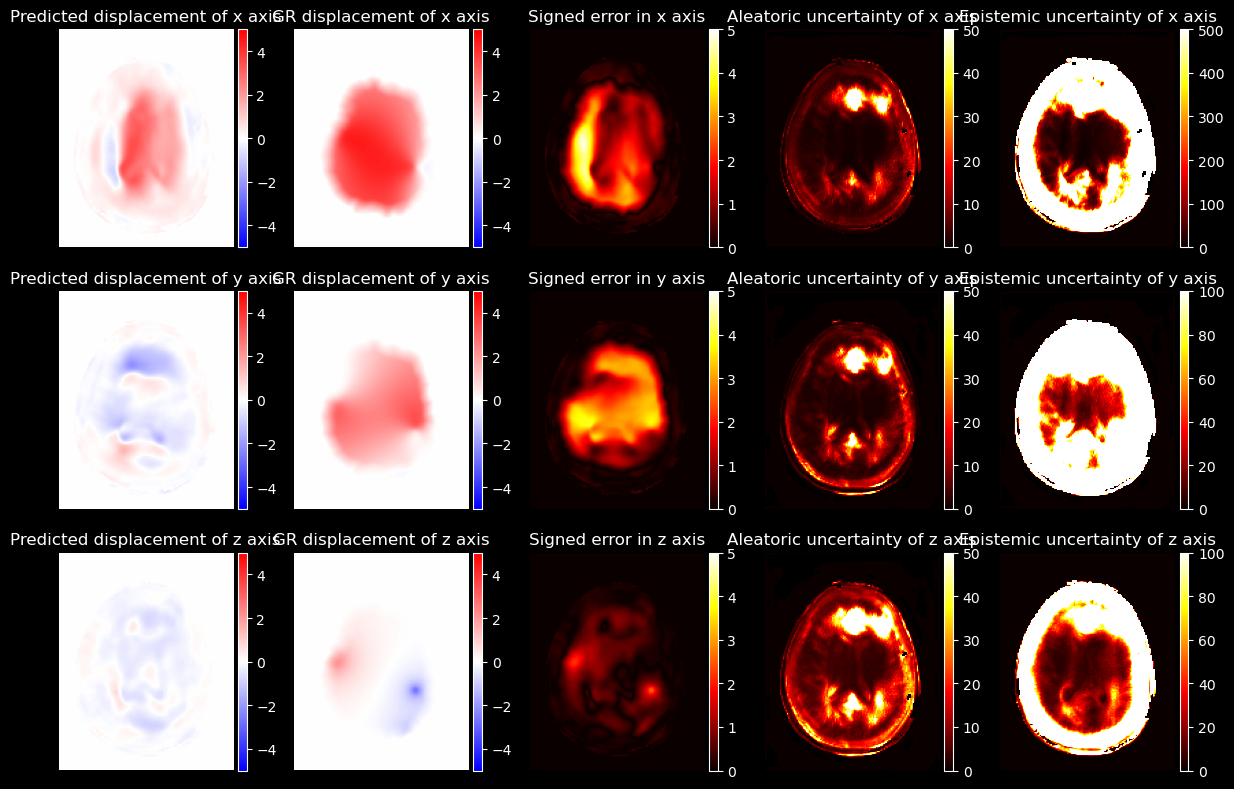

 30%|███       | 3/10 [00:31<01:14, 10.64s/it]/tmp/ipykernel_23370/1514950862.py:38: RuntimeWarning: invalid value encountered in multiply
  alx = (alea_x.cpu().numpy()[:,:,islice]*mask_head).T
/tmp/ipykernel_23370/1514950862.py:39: RuntimeWarning: invalid value encountered in multiply
  aly = (alea_y.cpu().numpy()[:,:,islice]*mask_head).T
/tmp/ipykernel_23370/1514950862.py:42: RuntimeWarning: invalid value encountered in multiply
  ex = (epi_x.cpu().numpy()[:,:,islice]*mask_head).T
/tmp/ipykernel_23370/1514950862.py:43: RuntimeWarning: invalid value encountered in multiply
  ey = (epi_y.cpu().numpy()[:,:,islice]*mask_head).T


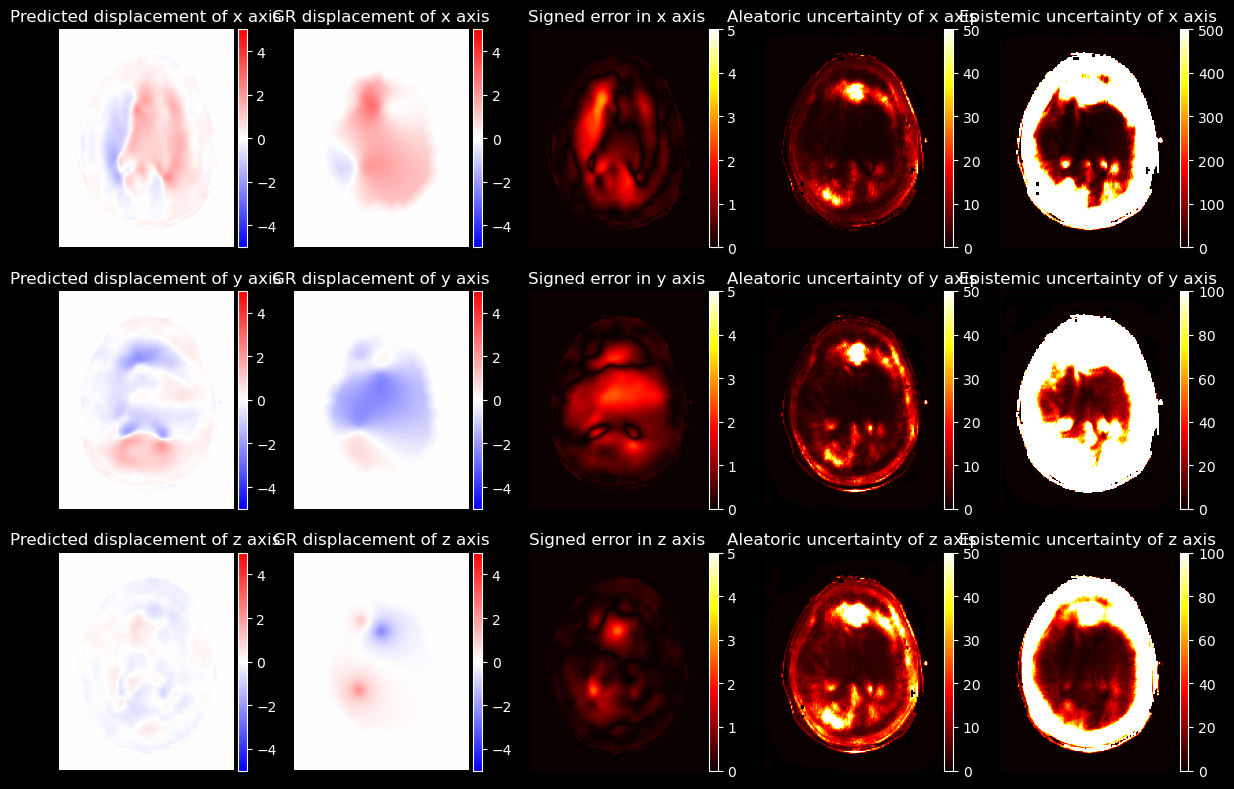

 40%|████      | 4/10 [00:41<01:02, 10.40s/it]/tmp/ipykernel_23370/1514950862.py:38: RuntimeWarning: invalid value encountered in multiply
  alx = (alea_x.cpu().numpy()[:,:,islice]*mask_head).T
/tmp/ipykernel_23370/1514950862.py:39: RuntimeWarning: invalid value encountered in multiply
  aly = (alea_y.cpu().numpy()[:,:,islice]*mask_head).T
/tmp/ipykernel_23370/1514950862.py:42: RuntimeWarning: invalid value encountered in multiply
  ex = (epi_x.cpu().numpy()[:,:,islice]*mask_head).T
/tmp/ipykernel_23370/1514950862.py:43: RuntimeWarning: invalid value encountered in multiply
  ey = (epi_y.cpu().numpy()[:,:,islice]*mask_head).T


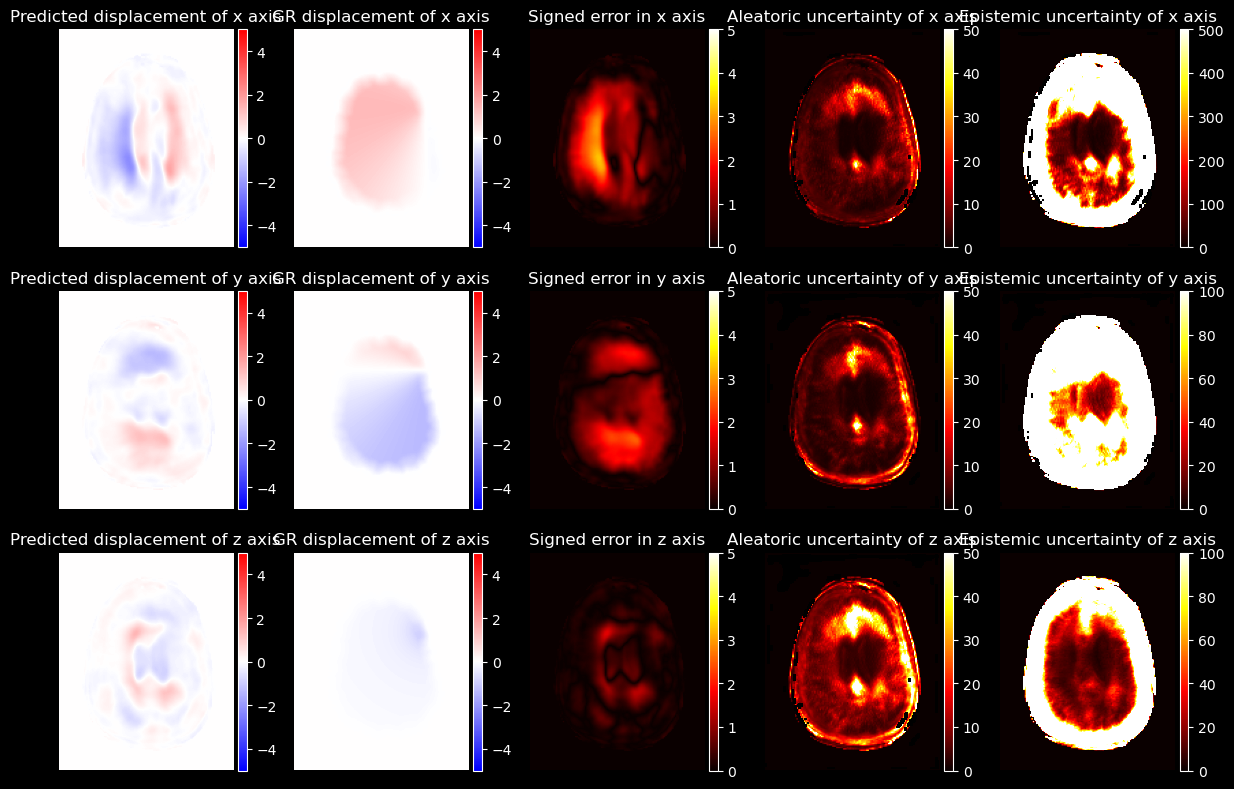

 50%|█████     | 5/10 [00:53<00:53, 10.79s/it]/tmp/ipykernel_23370/1514950862.py:38: RuntimeWarning: invalid value encountered in multiply
  alx = (alea_x.cpu().numpy()[:,:,islice]*mask_head).T
/tmp/ipykernel_23370/1514950862.py:39: RuntimeWarning: invalid value encountered in multiply
  aly = (alea_y.cpu().numpy()[:,:,islice]*mask_head).T
/tmp/ipykernel_23370/1514950862.py:42: RuntimeWarning: invalid value encountered in multiply
  ex = (epi_x.cpu().numpy()[:,:,islice]*mask_head).T
/tmp/ipykernel_23370/1514950862.py:43: RuntimeWarning: invalid value encountered in multiply
  ey = (epi_y.cpu().numpy()[:,:,islice]*mask_head).T


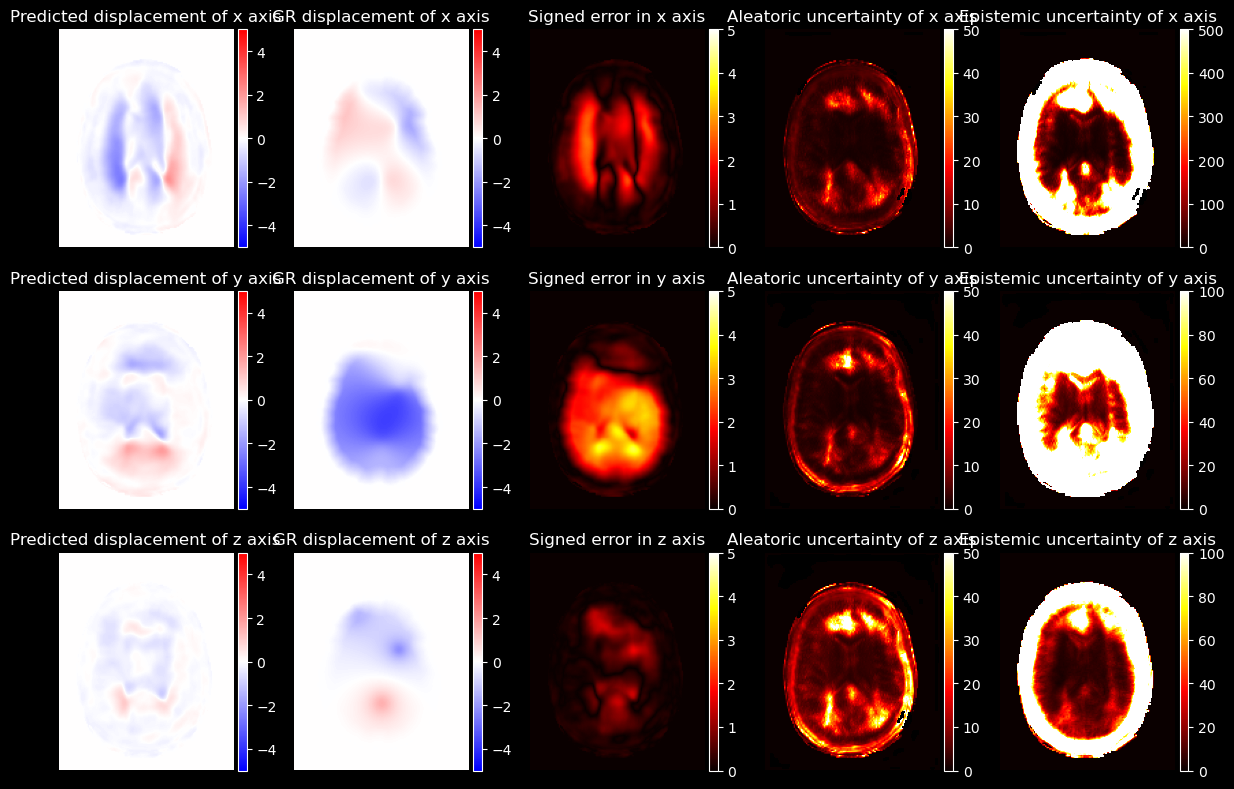

 60%|██████    | 6/10 [01:03<00:42, 10.68s/it]/tmp/ipykernel_23370/1514950862.py:38: RuntimeWarning: invalid value encountered in multiply
  alx = (alea_x.cpu().numpy()[:,:,islice]*mask_head).T
/tmp/ipykernel_23370/1514950862.py:39: RuntimeWarning: invalid value encountered in multiply
  aly = (alea_y.cpu().numpy()[:,:,islice]*mask_head).T
/tmp/ipykernel_23370/1514950862.py:42: RuntimeWarning: invalid value encountered in multiply
  ex = (epi_x.cpu().numpy()[:,:,islice]*mask_head).T
/tmp/ipykernel_23370/1514950862.py:43: RuntimeWarning: invalid value encountered in multiply
  ey = (epi_y.cpu().numpy()[:,:,islice]*mask_head).T


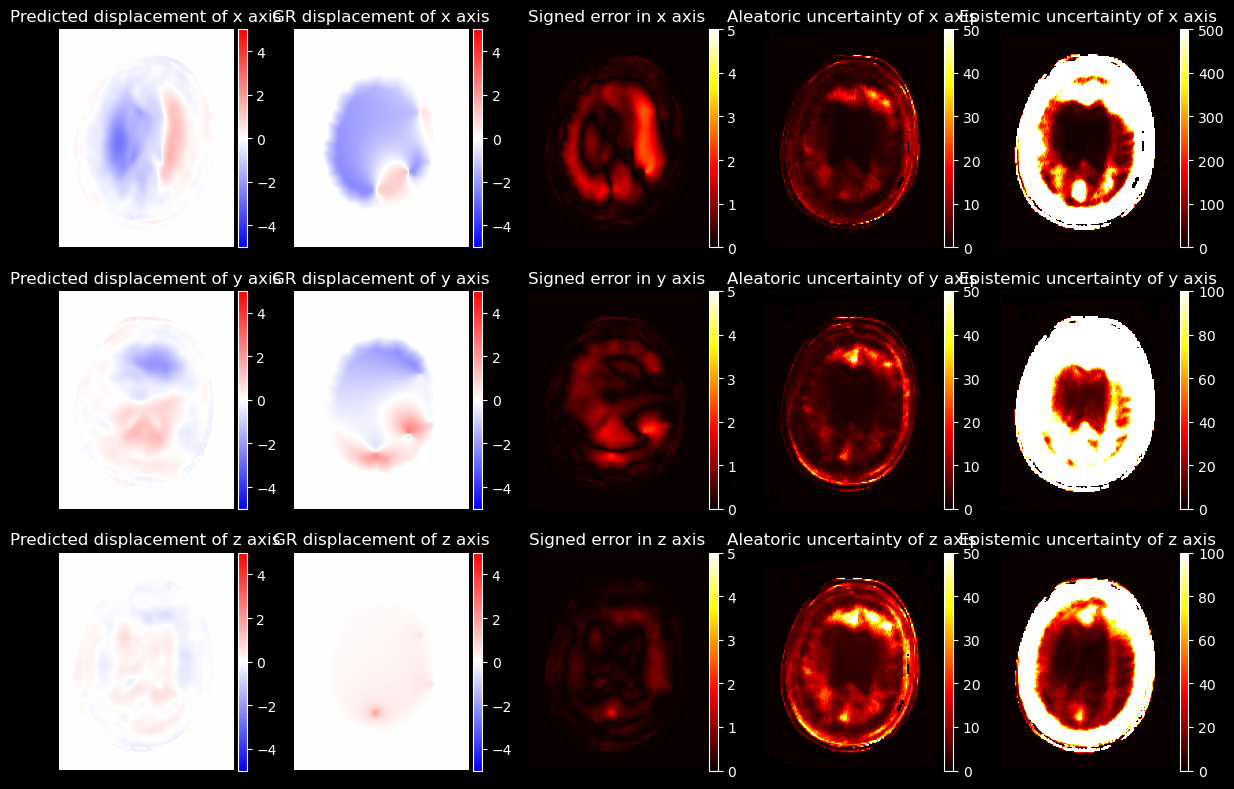

 70%|███████   | 7/10 [01:14<00:32, 10.77s/it]/tmp/ipykernel_23370/1514950862.py:38: RuntimeWarning: invalid value encountered in multiply
  alx = (alea_x.cpu().numpy()[:,:,islice]*mask_head).T
/tmp/ipykernel_23370/1514950862.py:39: RuntimeWarning: invalid value encountered in multiply
  aly = (alea_y.cpu().numpy()[:,:,islice]*mask_head).T
/tmp/ipykernel_23370/1514950862.py:42: RuntimeWarning: invalid value encountered in multiply
  ex = (epi_x.cpu().numpy()[:,:,islice]*mask_head).T
/tmp/ipykernel_23370/1514950862.py:43: RuntimeWarning: invalid value encountered in multiply
  ey = (epi_y.cpu().numpy()[:,:,islice]*mask_head).T


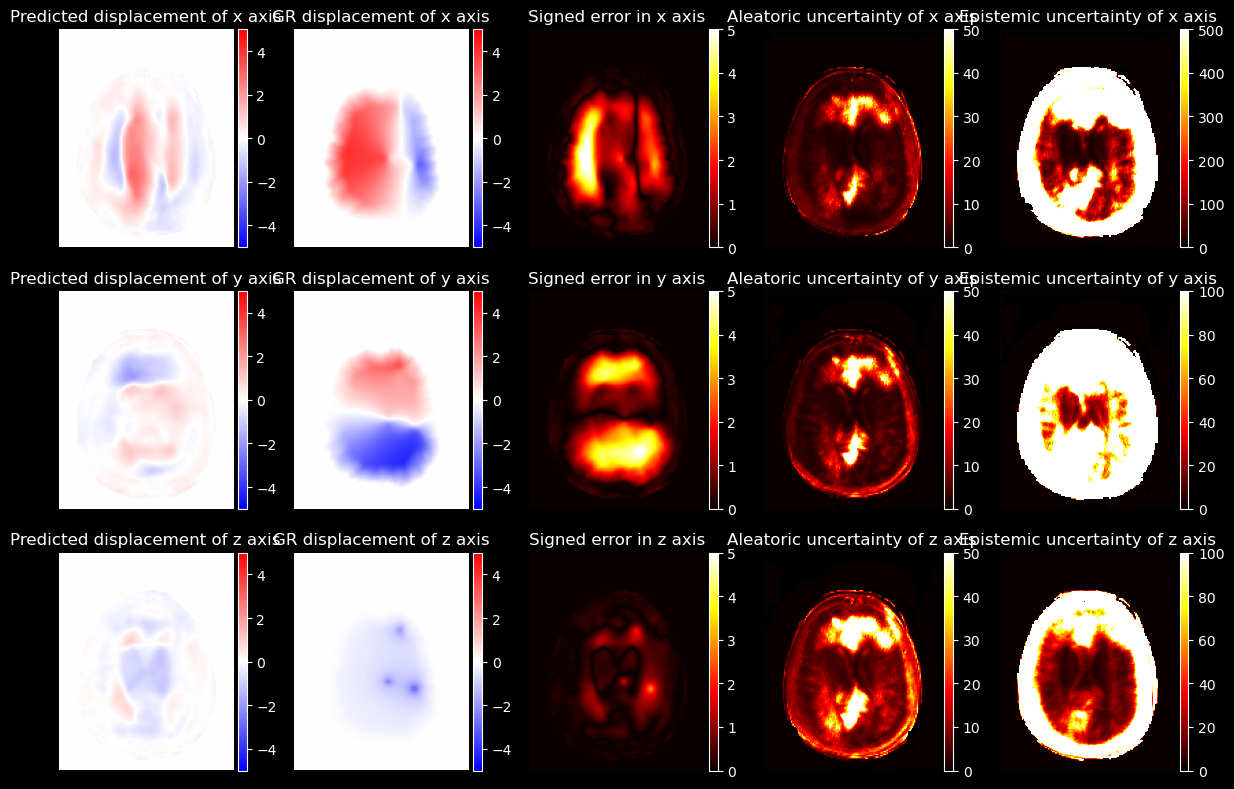

 80%|████████  | 8/10 [01:25<00:21, 10.65s/it]/tmp/ipykernel_23370/1514950862.py:38: RuntimeWarning: invalid value encountered in multiply
  alx = (alea_x.cpu().numpy()[:,:,islice]*mask_head).T
/tmp/ipykernel_23370/1514950862.py:39: RuntimeWarning: invalid value encountered in multiply
  aly = (alea_y.cpu().numpy()[:,:,islice]*mask_head).T
/tmp/ipykernel_23370/1514950862.py:42: RuntimeWarning: invalid value encountered in multiply
  ex = (epi_x.cpu().numpy()[:,:,islice]*mask_head).T
/tmp/ipykernel_23370/1514950862.py:43: RuntimeWarning: invalid value encountered in multiply
  ey = (epi_y.cpu().numpy()[:,:,islice]*mask_head).T


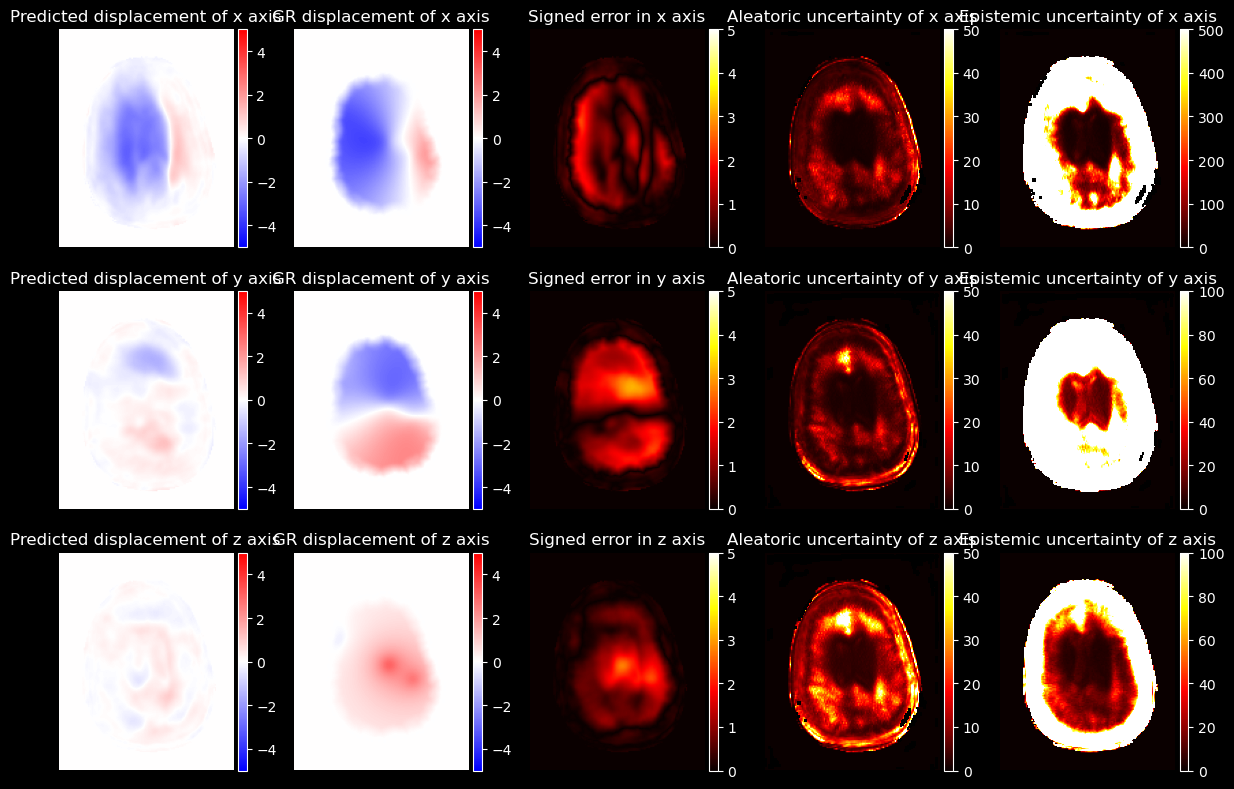

 90%|█████████ | 9/10 [01:35<00:10, 10.64s/it]/tmp/ipykernel_23370/1514950862.py:38: RuntimeWarning: invalid value encountered in multiply
  alx = (alea_x.cpu().numpy()[:,:,islice]*mask_head).T
/tmp/ipykernel_23370/1514950862.py:39: RuntimeWarning: invalid value encountered in multiply
  aly = (alea_y.cpu().numpy()[:,:,islice]*mask_head).T
/tmp/ipykernel_23370/1514950862.py:42: RuntimeWarning: invalid value encountered in multiply
  ex = (epi_x.cpu().numpy()[:,:,islice]*mask_head).T
/tmp/ipykernel_23370/1514950862.py:43: RuntimeWarning: invalid value encountered in multiply
  ey = (epi_y.cpu().numpy()[:,:,islice]*mask_head).T


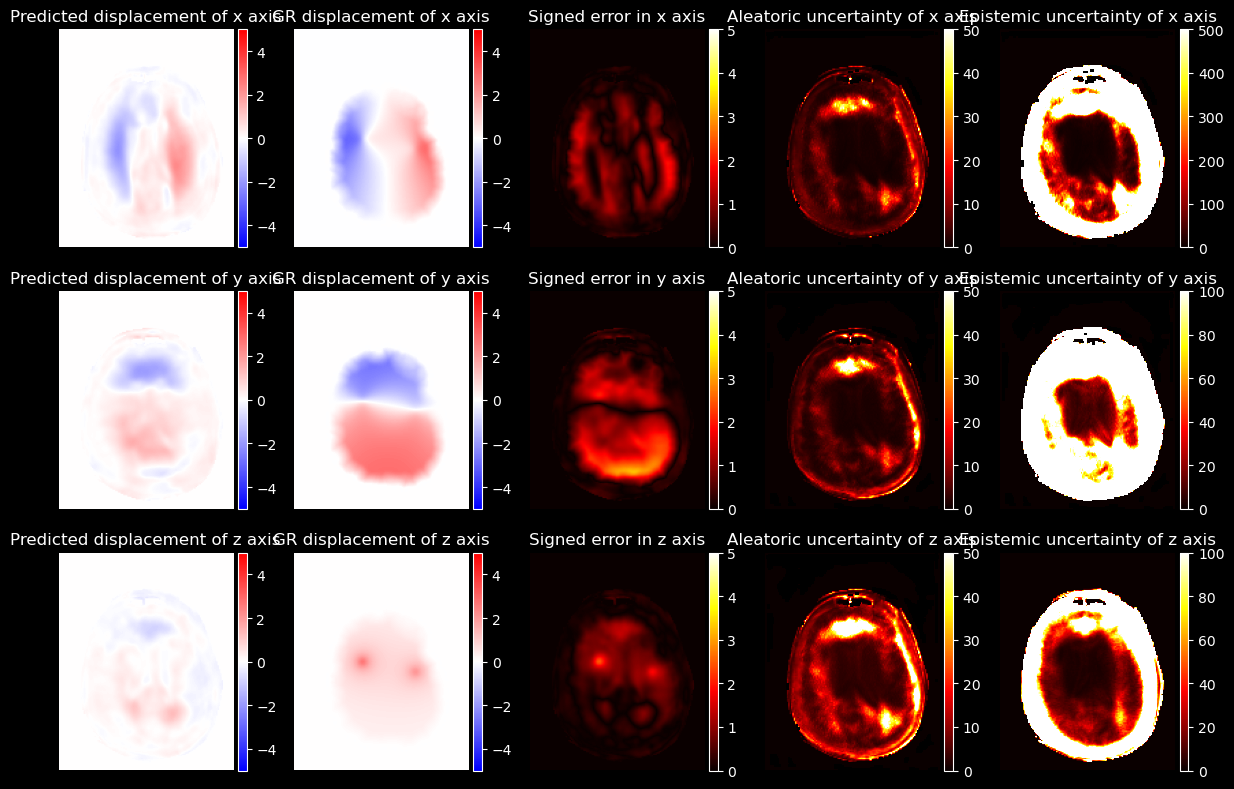

100%|██████████| 10/10 [01:46<00:00, 10.65s/it]


In [9]:
for i in tqdm(range(10)):
    data = valid_dataset[i]
    cbct_fixed = data[0].to(device).to(device)
    mr_moving = data[1].to(device).to(device)
    ct_fixed = data[2].to(device)
    ct_moving = data[3].to(device)
    gt = torch.from_numpy(data[-1]).to(device)
    # gt = data[-1].to(device)
    with torch.no_grad():
        flows,_, _ = G(mr_moving, cbct_fixed)
        mr_reg = vxm.layers.SpatialTransformer([128,160,128], mode='bilinear').to(device)(mr_moving, flows[0])
        uncert = flows[4]
        # uncert = torch.clamp(flows[4],min=1e-4)
        alpha_x = uncert[0,0,:,:,:]+1
        beta_x = uncert[0,1,:,:,:]
        mu_x = uncert[0,2,:,:,:]
        omega_x = 2*beta_x*(1+mu_x)
        alpha_y = uncert[0,3,:,:,:]+1
        beta_y = uncert[0,4,:,:,:]
        mu_y = uncert[0,5,:,:,:]
        omega_y = 2*beta_y*(1+mu_y)
        alpha_z = uncert[0,6,:,:,:]+1
        beta_z = uncert[0,7,:,:,:]
        mu_z = uncert[0,8,:,:,:]
        omega_z = 2*beta_z*(1+mu_z)    
    alea_x = beta_x/(alpha_x-1)
    alea_y = beta_y/(alpha_y-1)
    alea_z = beta_z/(alpha_z-1)

    epi_x = beta_x/(mu_x*(alpha_x-1))
    epi_y = beta_y/(mu_y*(alpha_y-1))
    epi_z = beta_z/(mu_z*(alpha_z-1))
    plt.style.use('dark_background')
    islice = 72
    mask_head = (cbct_fixed[0,0,:,:,islice].cpu().numpy()>0.05).astype(int)
    fig, ax = plt.subplots(3,5,figsize=(12,8))
    np.vectorize(lambda ax: ax.axis('off'))(ax)
    alx = (alea_x.cpu().numpy()[:,:,islice]*mask_head).T
    aly = (alea_y.cpu().numpy()[:,:,islice]*mask_head).T
    alz = (alea_z.cpu().numpy()[:,:,islice]*mask_head).T
    
    ex = (epi_x.cpu().numpy()[:,:,islice]*mask_head).T
    ey = (epi_y.cpu().numpy()[:,:,islice]*mask_head).T
    ez = (epi_z.cpu().numpy()[:,:,islice]*mask_head).T
    
    imx1 = ax[0][3].imshow(alx, cmap='hot', vmin=0,vmax = 50)
    divider = make_axes_locatable(ax[0][3])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imx1, cax=cax, orientation='vertical')
    ax[0][3].set_title('Aleatoric uncertainty of x axis')
    imy1 = ax[1][3].imshow(aly, cmap='hot', vmin=0,vmax = 50)
    divider = make_axes_locatable(ax[1][3])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imy1, cax=cax, orientation='vertical')
    ax[1][3].set_title('Aleatoric uncertainty of y axis')
    imz1 = ax[2][3].imshow(alx+aly+alz, cmap='hot', vmin=0,vmax = 50)
    divider = make_axes_locatable(ax[2][3])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imz1, cax=cax, orientation='vertical')
    ax[2][3].set_title('Aleatoric uncertainty of z axis')

    imx2 = ax[0][4].imshow(ex, cmap='hot', vmin=0,vmax = 500)
    divider = make_axes_locatable(ax[0][4])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imx2, cax=cax, orientation='vertical')
    ax[0][4].set_title('Epistemic uncertainty of x axis')
    imy2 = ax[1][4].imshow(ey, cmap='hot', vmin=0,vmax = 100)
    divider = make_axes_locatable(ax[1][4])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imy2, cax=cax, orientation='vertical')

    ax[1][4].set_title('Epistemic uncertainty of y axis')
    imz2 = ax[2][4].imshow(ez, cmap='hot', vmin=0,vmax = 100)
    divider = make_axes_locatable(ax[2][4])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imz2, cax=cax, orientation='vertical')
    ax[2][4].set_title('Epistemic uncertainty of z axis')
    pred = flows[0]
    
    imx1 = ax[0][0].imshow(pred[0,0,:,:,islice].T*mask_head.T, cmap = 'bwr',vmin=-5,vmax = 5)
    divider = make_axes_locatable(ax[0][0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imx1, cax=cax, orientation='vertical')
    ax[0][0].set_title('Predicted displacement of x axis')
    imy1 = ax[1][0].imshow(pred[0,1,:,:,islice].T*mask_head.T,cmap = 'bwr', vmin=-5,vmax = 5)
    divider = make_axes_locatable(ax[1][0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imy1, cax=cax, orientation='vertical')
    ax[1][0].set_title('Predicted displacement of y axis')
    imz1 = ax[2][0].imshow(pred[0,2,:,:,islice].T*mask_head.T, cmap = 'bwr',vmin=-5,vmax = 5)
    divider = make_axes_locatable(ax[2][0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imz1, cax=cax, orientation='vertical')
    ax[2][0].set_title('Predicted displacement of z axis')

    imx2 = ax[0][1].imshow(-gt[0,0,:,:,islice].T,cmap = 'bwr', vmin=-5,vmax = 5)
    divider = make_axes_locatable(ax[0][1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imx2, cax=cax, orientation='vertical')
    ax[0][1].set_title('GR displacement of x axis')
    imy2 = ax[1][1].imshow(-gt[0,1,:,:,islice].T,cmap = 'bwr', vmin=-5,vmax = 5)
    divider = make_axes_locatable(ax[1][1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imy2, cax=cax, orientation='vertical')
    ax[1][1].set_title('GR displacement of y axis')
    imz2 = ax[2][1].imshow(-gt[0,2,:,:,islice].T,cmap = 'bwr', vmin=-5,vmax = 5)
    divider = make_axes_locatable(ax[2][1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imz2, cax=cax, orientation='vertical')
    ax[2][1].set_title('GR displacement of z axis')
    
    
    imx2 = ax[0][2].imshow(abs((flows[0][0,0,:,:,islice]+gt[0,0,:,:,islice])*mask_head).T,cmap = 'hot', vmin=0,vmax = 5)
    divider = make_axes_locatable(ax[0][2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imx2, cax=cax, orientation='vertical')
    ax[0][2].set_title('Signed error in x axis')
    imy2 = ax[1][2].imshow(abs((flows[0][0,1,:,:,islice]+gt[0,1,:,:,islice])*mask_head).T,cmap = 'hot', vmin=0,vmax = 5)
    divider = make_axes_locatable(ax[1][2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imy2, cax=cax, orientation='vertical')
    ax[1][2].set_title('Signed error in y axis')
    imz2 = ax[2][2].imshow(abs((flows[0][0,2,:,:,islice]+gt[0,2,:,:,islice])*mask_head).T,cmap = 'hot', vmin=0,vmax = 5)
    divider = make_axes_locatable(ax[2][2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imz2, cax=cax, orientation='vertical')
    ax[2][2].set_title('Signed error in z axis')

    plt.tight_layout()
    plt.show()


  0%|          | 0/10 [00:00<?, ?it/s]

flow4_input:0.1864
STN4_1:0.4905 z4_tgt:0.2101 r4:0.3153 flow4 weight:0.0062 unc_flow:-0.1916 STN4_2:-0.1882 flow4_output:-0.0016


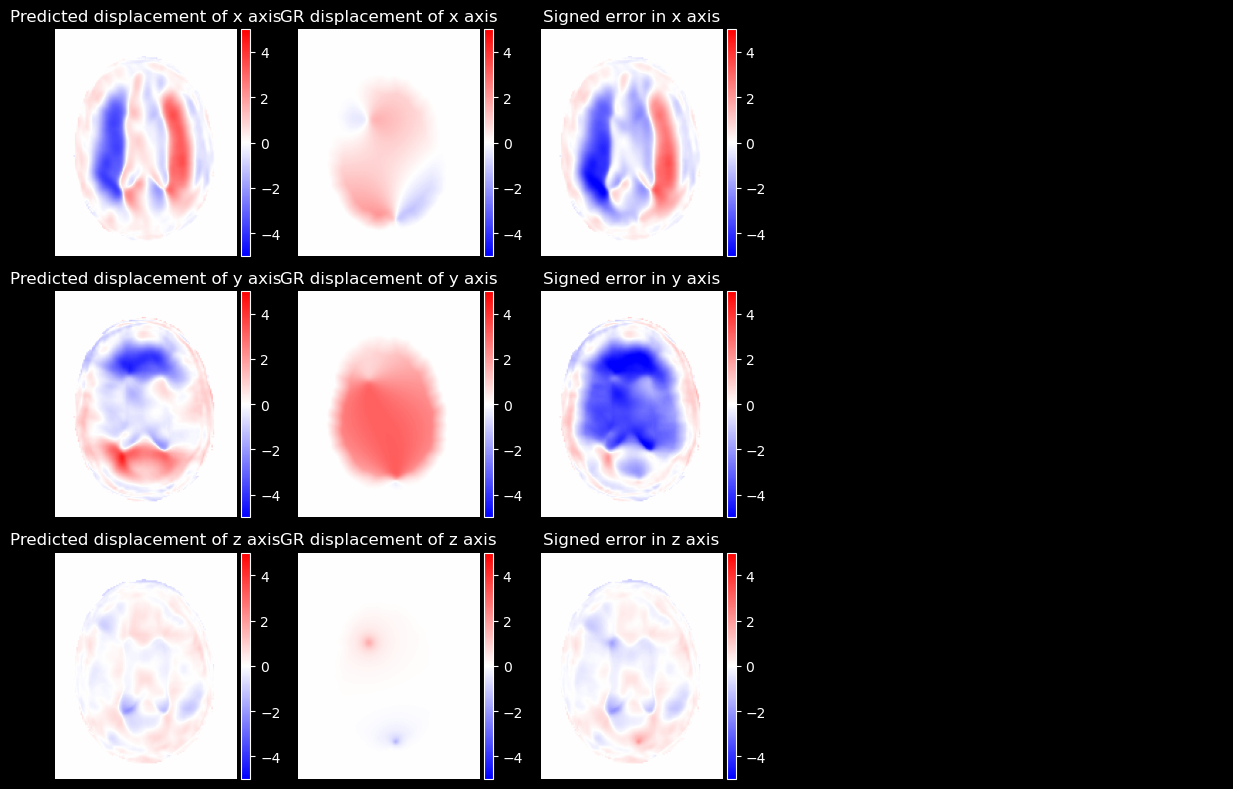

 10%|█         | 1/10 [00:19<02:58, 19.83s/it]

flow4_input:0.2254
STN4_1:0.5031 z4_tgt:0.2048 r4:0.3032 flow4 weight:0.0062 unc_flow:-0.1933 STN4_2:-0.1895 flow4_output:0.0360


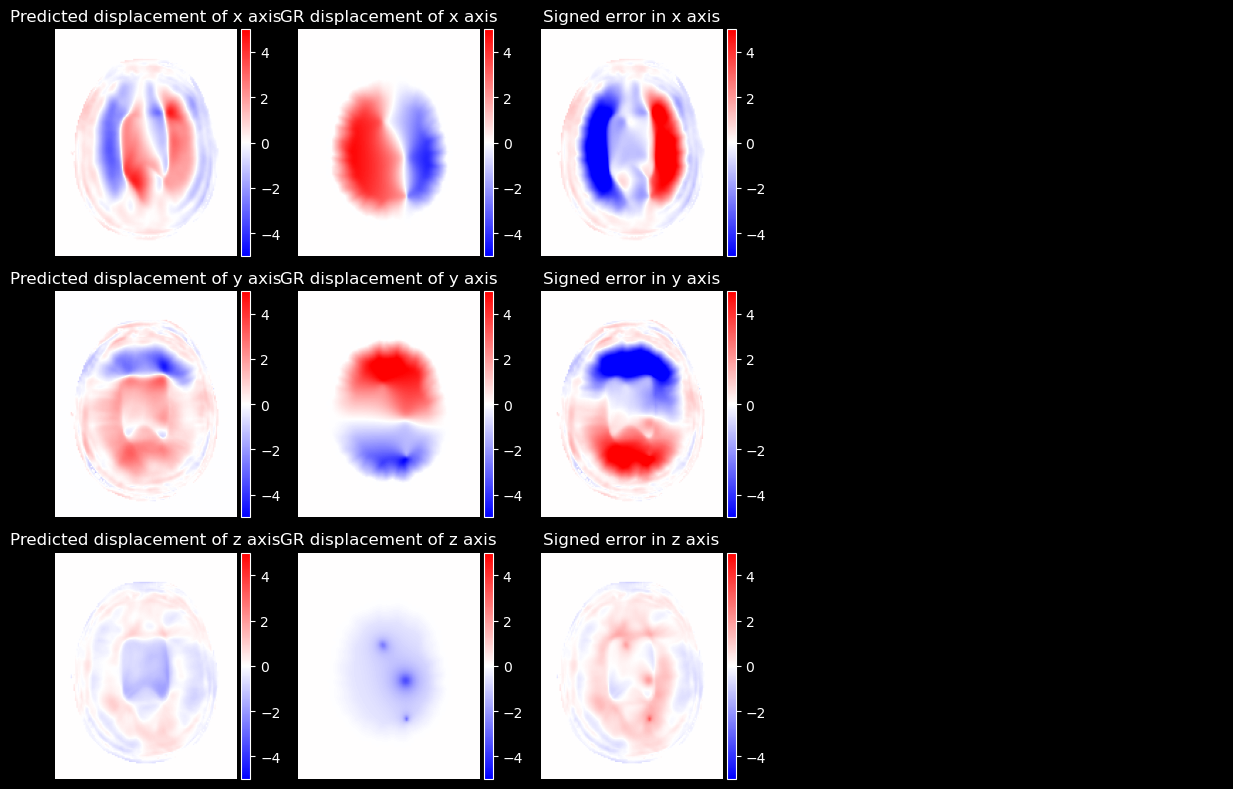

 20%|██        | 2/10 [00:46<03:07, 23.45s/it]


KeyboardInterrupt: 

In [5]:
for i in tqdm(range(10)):
    data = valid_dataset[i]
    cbct_fixed = data[0].to(device).to(device)
    mr_moving = data[1].to(device).to(device)
    ct_fixed = data[2].to(device)
    ct_moving = data[3].to(device)
    gt = torch.from_numpy(data[-1]).to(device)
    with torch.no_grad():
        flows,_, _ = G(mr_moving, cbct_fixed)
        mr_reg = vxm.layers.SpatialTransformer([128,160,128], mode='bilinear').to(device)(mr_moving, flows[0])
        pred = flows[0]
    plt.style.use('dark_background')
    islice = 72
    mask_head = (cbct_fixed[0,0,:,:,islice].cpu().numpy()>0.05).astype(int)
    fig, ax = plt.subplots(3,5,figsize=(12,8))
    np.vectorize(lambda ax: ax.axis('off'))(ax)
    
    imx1 = ax[0][0].imshow(pred[0,0,:,:,islice].T*mask_head.T, cmap = 'bwr',vmin=-5,vmax = 5)
    divider = make_axes_locatable(ax[0][0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imx1, cax=cax, orientation='vertical')
    ax[0][0].set_title('Predicted displacement of x axis')
    imy1 = ax[1][0].imshow(pred[0,1,:,:,islice].T*mask_head.T,cmap = 'bwr', vmin=-5,vmax = 5)
    divider = make_axes_locatable(ax[1][0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imy1, cax=cax, orientation='vertical')
    ax[1][0].set_title('Predicted displacement of y axis')
    imz1 = ax[2][0].imshow(pred[0,2,:,:,islice].T*mask_head.T, cmap = 'bwr',vmin=-5,vmax = 5)
    divider = make_axes_locatable(ax[2][0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imz1, cax=cax, orientation='vertical')
    ax[2][0].set_title('Predicted displacement of z axis')

    imx2 = ax[0][1].imshow(-gt[0,0,:,:,islice].T,cmap = 'bwr', vmin=-5,vmax = 5)
    divider = make_axes_locatable(ax[0][1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imx2, cax=cax, orientation='vertical')
    ax[0][1].set_title('GR displacement of x axis')
    imy2 = ax[1][1].imshow(-gt[0,1,:,:,islice].T,cmap = 'bwr', vmin=-5,vmax = 5)
    divider = make_axes_locatable(ax[1][1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imy2, cax=cax, orientation='vertical')
    ax[1][1].set_title('GR displacement of y axis')
    imz2 = ax[2][1].imshow(-gt[0,2,:,:,islice].T,cmap = 'bwr', vmin=-5,vmax = 5)
    divider = make_axes_locatable(ax[2][1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imz2, cax=cax, orientation='vertical')
    ax[2][1].set_title('GR displacement of z axis')
    
    
    imx2 = ax[0][2].imshow(((flows[0][0,0,:,:,islice]+gt[0,0,:,:,islice])*mask_head).T,cmap = 'bwr', vmin=-5,vmax = 5)
    divider = make_axes_locatable(ax[0][2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imx2, cax=cax, orientation='vertical')
    ax[0][2].set_title('Signed error in x axis')
    imy2 = ax[1][2].imshow(((flows[0][0,1,:,:,islice]+gt[0,1,:,:,islice])*mask_head).T,cmap = 'bwr', vmin=-5,vmax = 5)
    divider = make_axes_locatable(ax[1][2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imy2, cax=cax, orientation='vertical')
    ax[1][2].set_title('Signed error in y axis')
    imz2 = ax[2][2].imshow(((flows[0][0,2,:,:,islice]+gt[0,2,:,:,islice])*mask_head).T,cmap = 'bwr', vmin=-5,vmax = 5)
    divider = make_axes_locatable(ax[2][2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imz2, cax=cax, orientation='vertical')
    ax[2][2].set_title('Signed error in z axis')

    plt.tight_layout()
    plt.show()


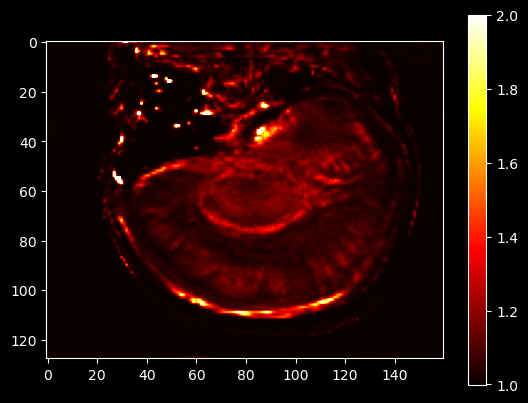

In [40]:
plt.imshow(alpha_x[72,:,:].T,cmap = 'hot',vmin = 1,vmax = 2)
plt.colorbar()

In [42]:
alpha_x.max(),beta_x.max(), mu_x.max(),alpha_x.min(),beta_x.min(), mu_x.min()

(tensor(15.4545),
 tensor(1197.0865),
 tensor(881.5322),
 tensor(1.0019),
 tensor(4.8459e-10),
 tensor(1.3766e-06))

10


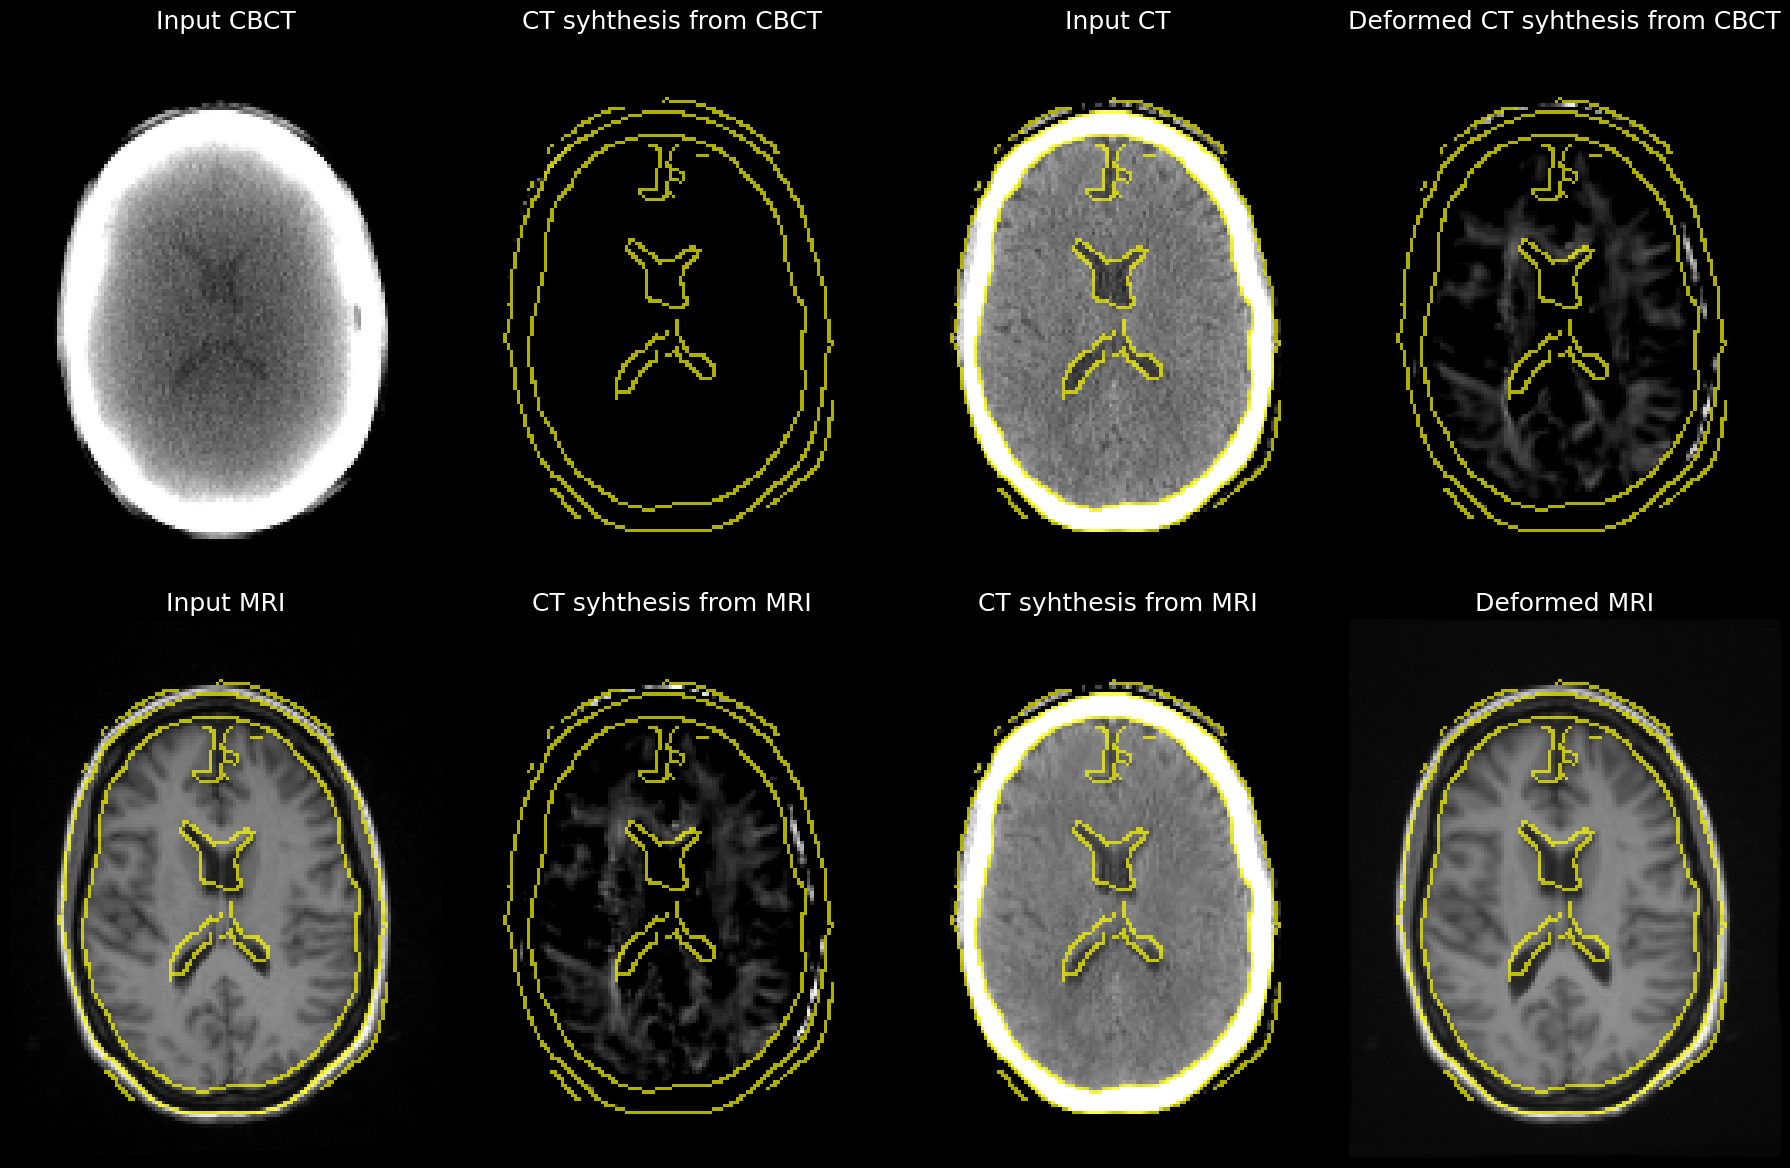

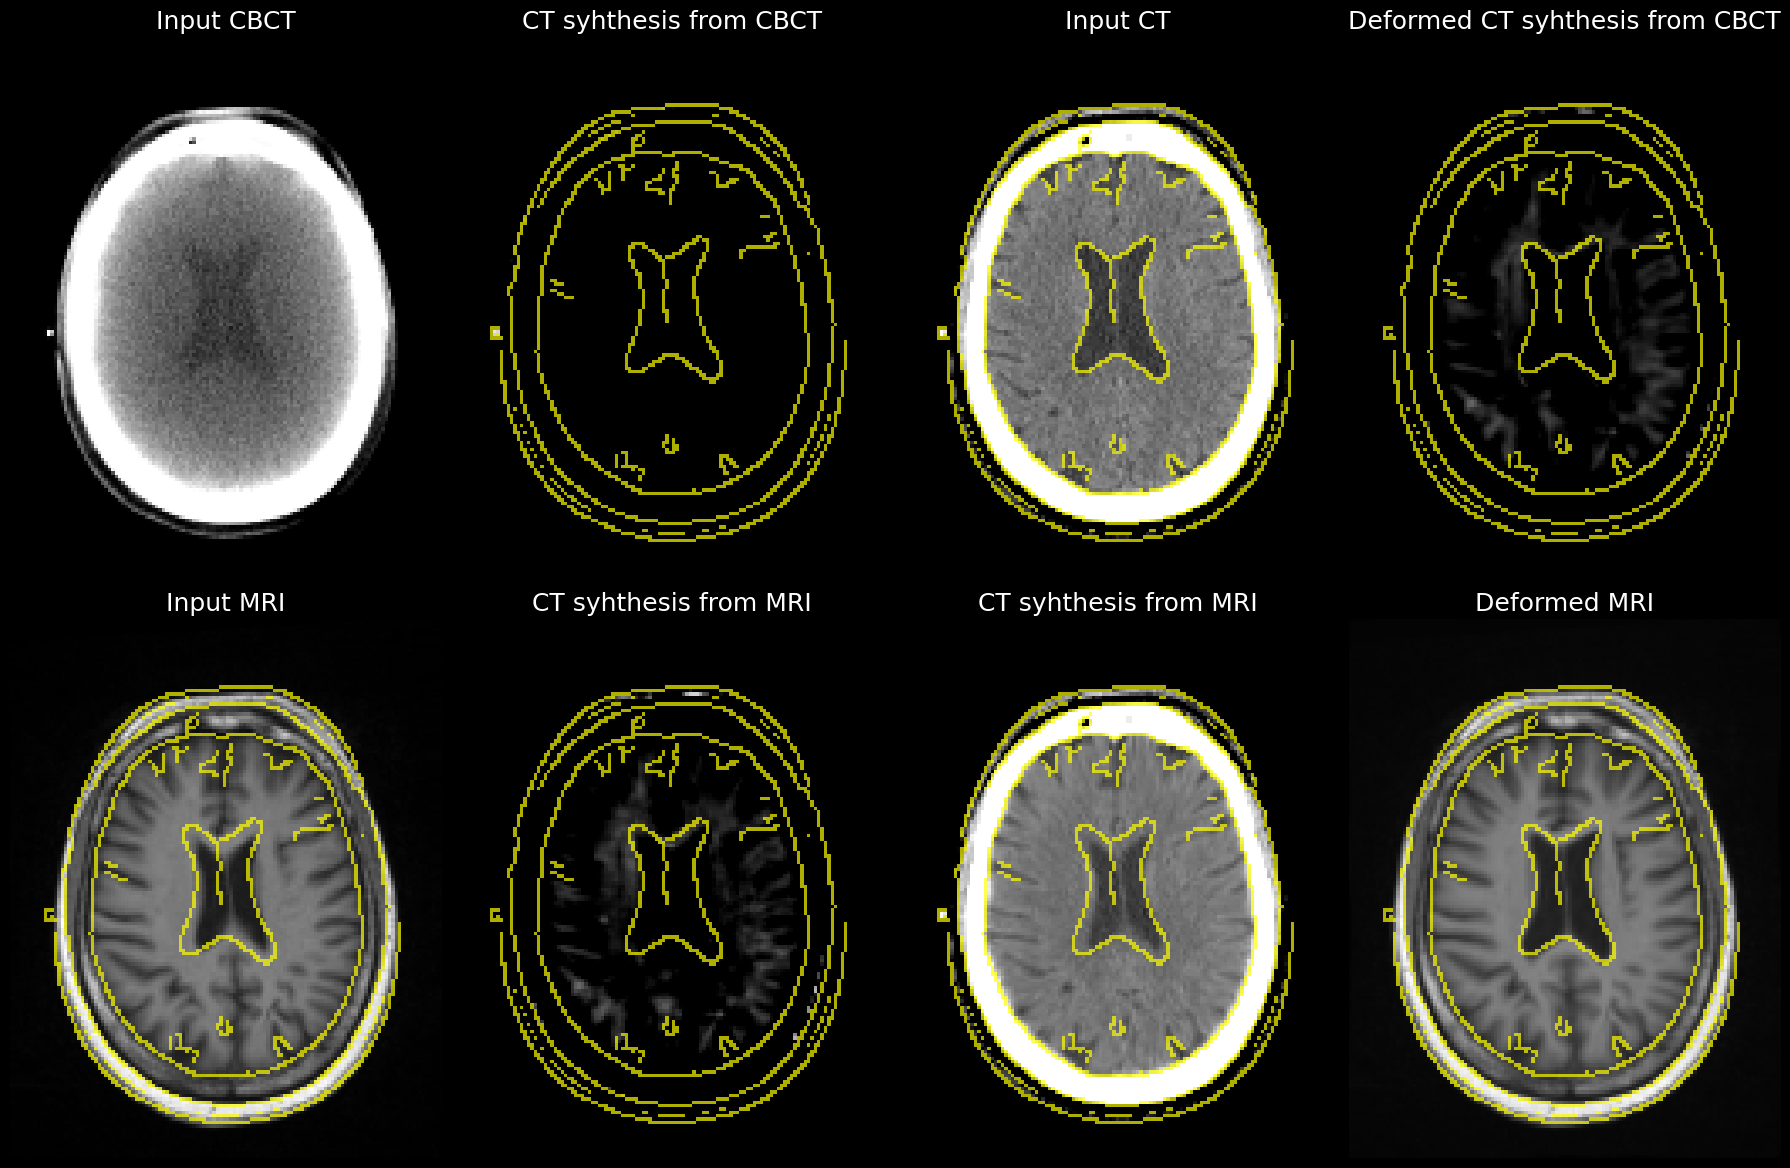

/home/myi16/anaconda3/envs/jsr_Y/lib/python3.9/site-packages/scipy/ndimage/measurements.py:1406: RuntimeWarning: invalid value encountered in double_scalars
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


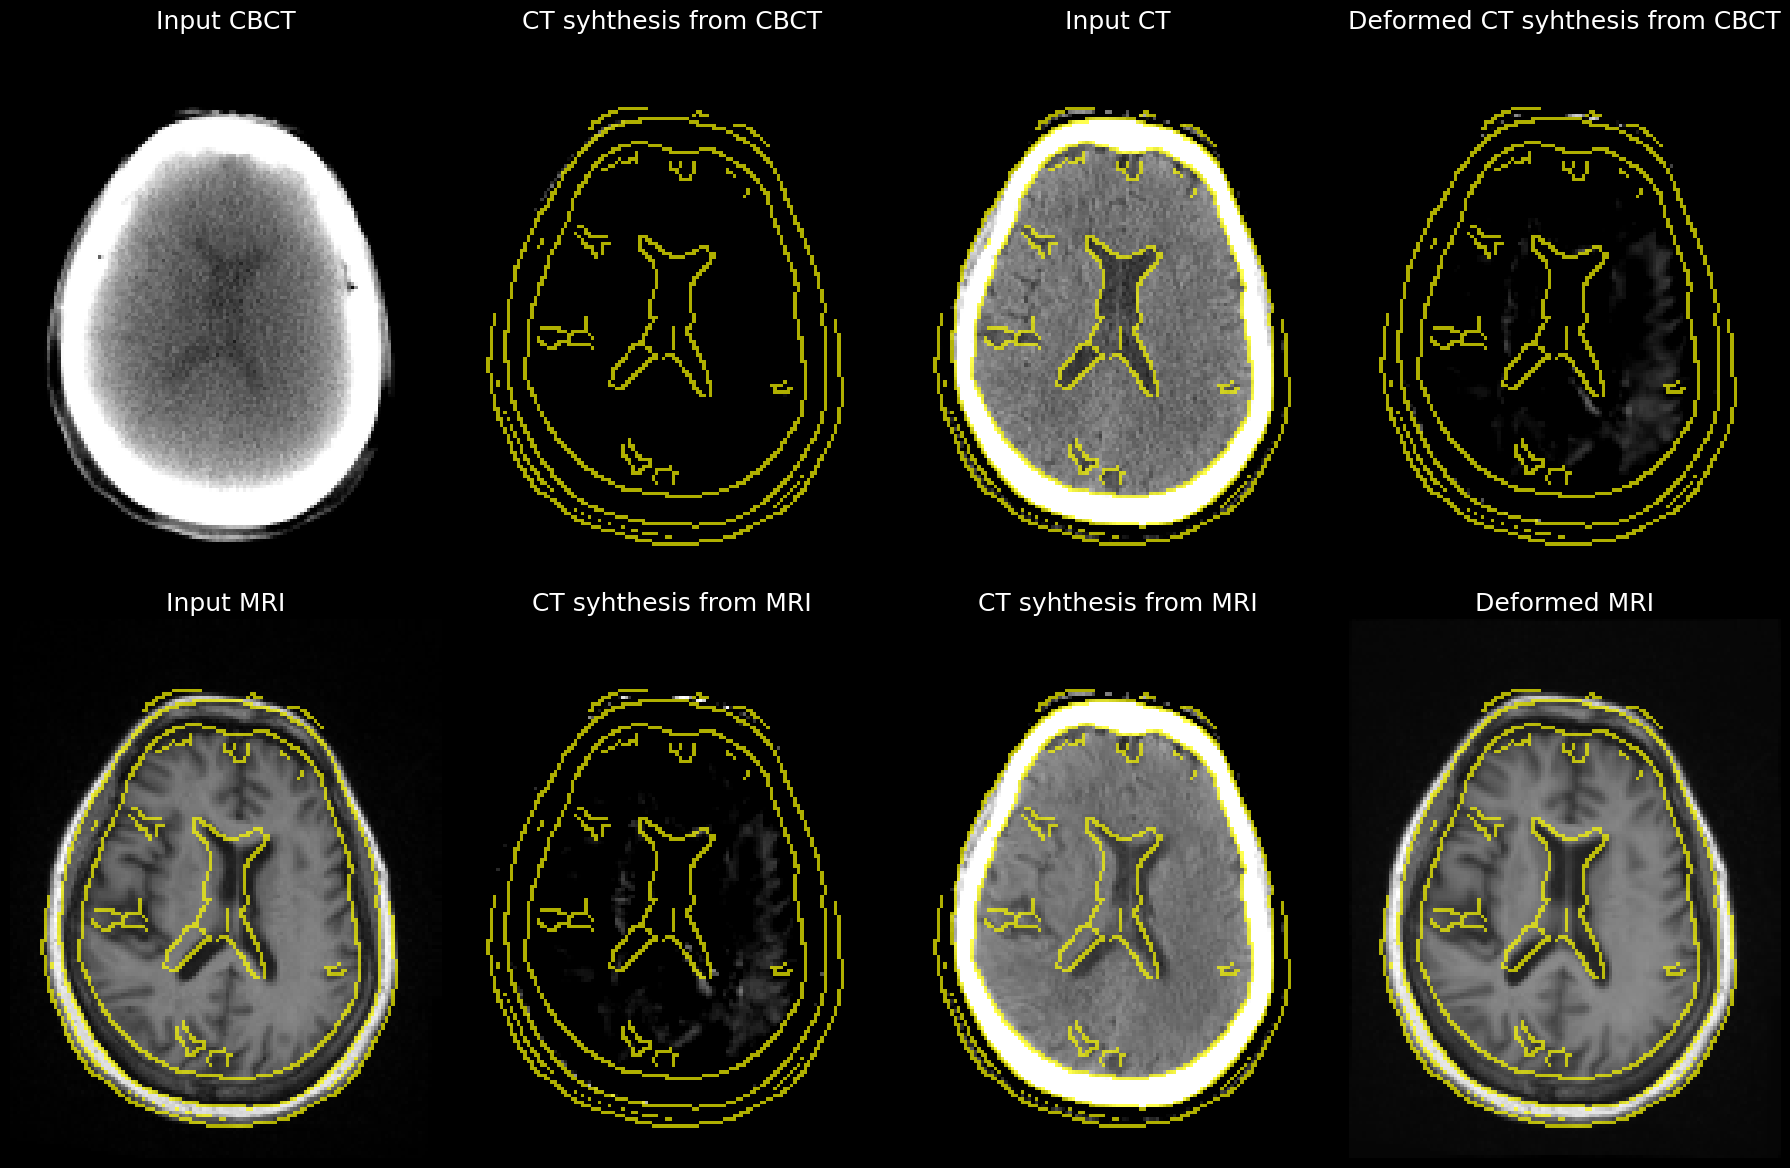

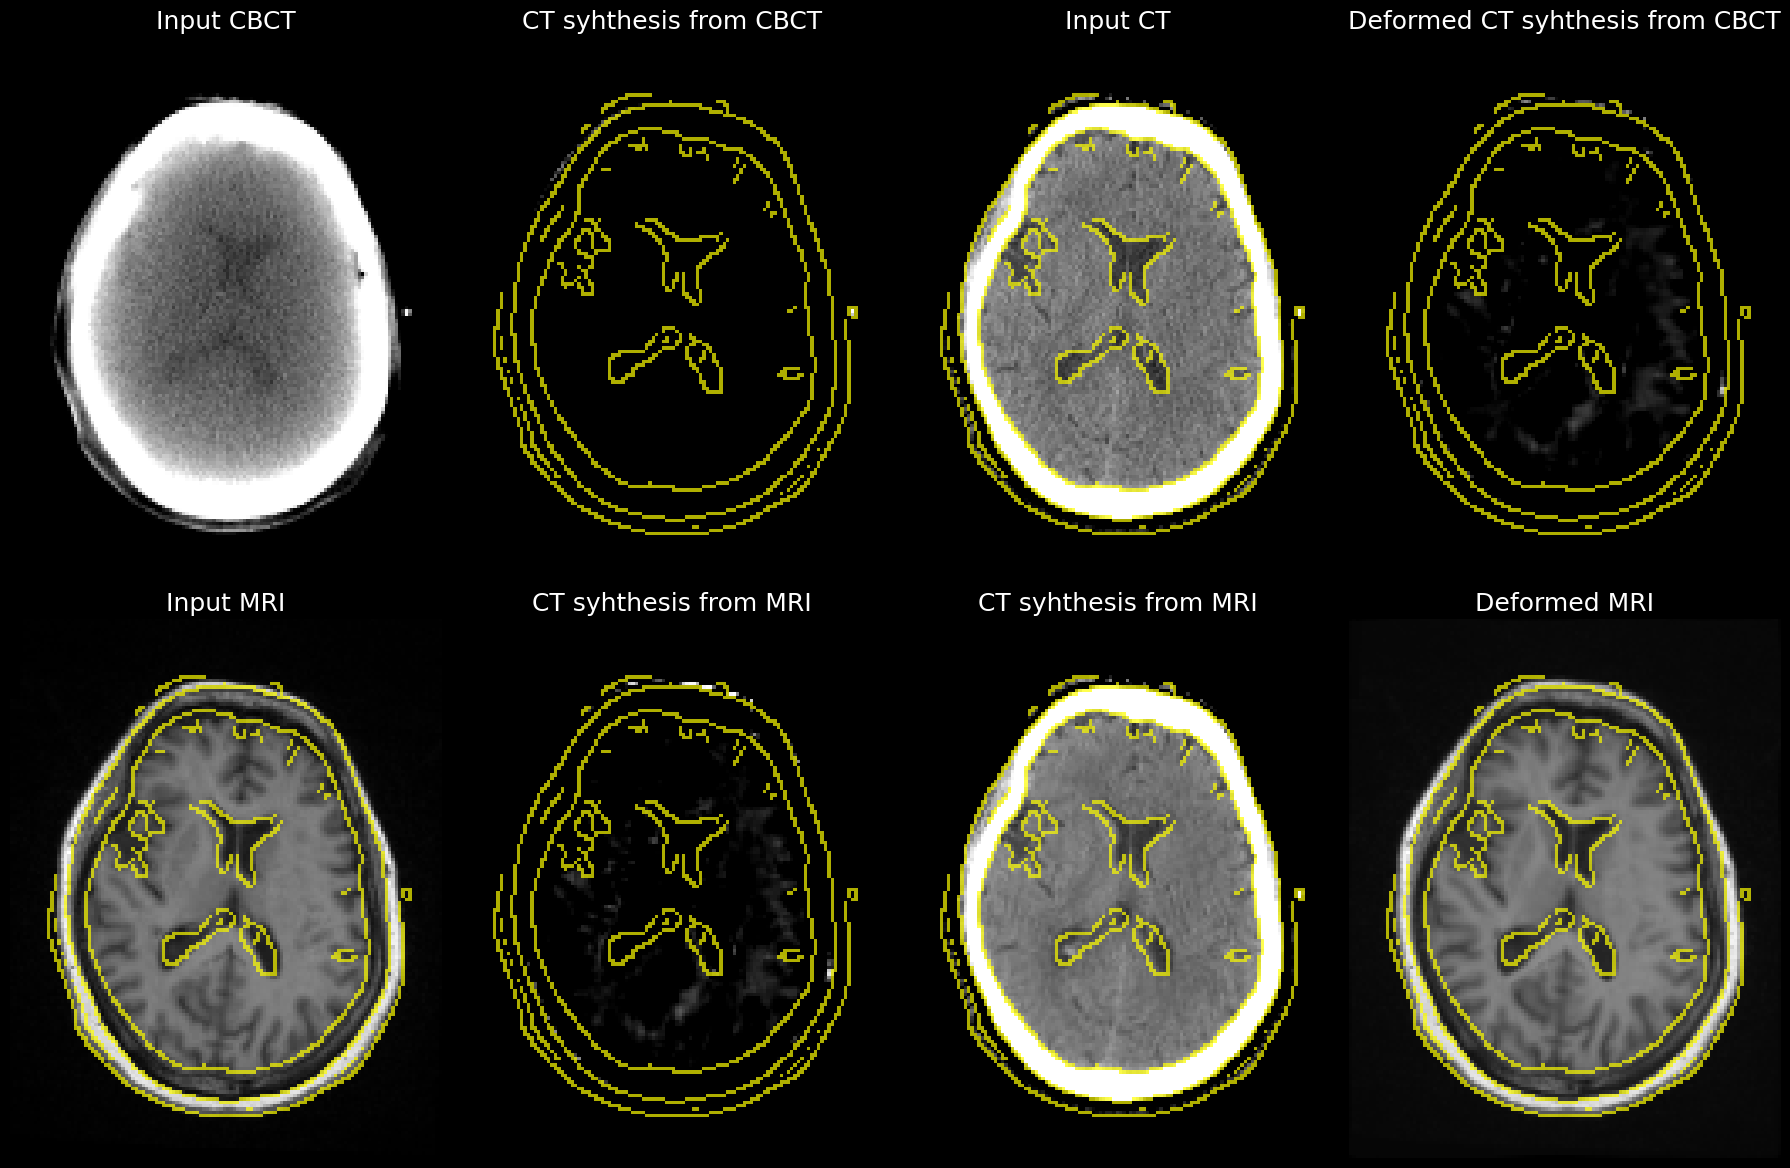

KeyboardInterrupt: 

In [16]:
metrics = pd.DataFrame()
mask_val = [1,2,23,5,19,29,8]
# valid_dataset = RadOncTrainingDataset("/home/myi16/jsr_Y/new_val", num_samples=10, transform=False,
#                                           supervision=True, return_segmentation=True)
print(len(valid_dataset))
for ep in range(1):
    G.load_state_dict(checkpoint['G_state_dict'])
    dice_before_total = []
    dice_after_total = []
    hd_before_total = []
    sd_before_total = []
    hd_after_total = []
    sd_after_total = []
    tre_before_total = []
    tre_after_total = []
    
    for i in range(10):
        cbct_fixed, mr_moving, ct_fixed, ct_moving, seg_fixed, seg_moving,gt,flow = valid_dataset[i]
        cbct_fixed = cbct_fixed.float().to(device)
        mr_moving = mr_moving.float().to(device)
        ct_fixed = ct_fixed.float().to(device)
        ct_moving = ct_moving.float().to(device)
        seg_fixed = seg_fixed.float().to(device)
        seg_moving = seg_moving.float().to(device)
        
        # cbct_fixed = torch.from_numpy(cbct_fixed).to(device).unsqueeze(0).unsqueeze(0).to(device)
        # mr_moving = torch.from_numpy(mr_moving).to(device).unsqueeze(0).unsqueeze(0).to(device)
        # ct_fixed = torch.from_numpy(ct_fixed).to(device)
        # ct_moving = torch.from_numpy(ct_moving).to(device)
        # seg_fixed =  torch.from_numpy(seg_fixed).float().unsqueeze(0).to(device)
        # seg_moving =  torch.from_numpy(seg_moving).float().unsqueeze(0).to(device)
        
        # print(cbct_fixed.shape, mr_moving.shape, ct_fixed.shape, ct_moving.shape, seg_fixed.shape, seg_moving.shape)
        # torch.Size([1, 1, 128, 160, 128]) torch.Size([1, 1, 128, 160, 128]) torch.Size([128, 160, 128]) torch.Size([128, 160, 128]) torch.Size([1, 7, 128, 160, 128]) torch.Size([1, 7, 128, 160, 128])
        with torch.no_grad():
            flow, ct_moving_synth, ct_fixed_synth = G(mr_moving, cbct_fixed)

            # the flow[0] means the final highest resolution from the cascade network.
            mr_reg = vxm.layers.SpatialTransformer([128,160,128], mode='bilinear').to(device)(mr_moving, flow[0])
            ct_reg_synth = vxm.layers.SpatialTransformer([128,160,128], mode='bilinear').to(device)(ct_moving_synth[0], flow[0])
            seg_reg = vxm.layers.SpatialTransformer([128,160,128], mode='nearest').to(device)(seg_moving, flow[0])

            dice_before = []
            hd_before = []
            sd_before = []
            dice_after= []
            hd_after = []
            sd_after = []
            for j, val in enumerate(mask_val):
                mask_fixed = seg_fixed[:,j:j+1,:,:,:]
                mask_moving = seg_moving[:,j:j+1,:,:,:]
                mask_registered = seg_reg[:,j:j+1,:,:,:]
                dice_before.append(-losses.Dice().loss(mask_fixed,mask_moving).item())
                dice_after.append(-losses.Dice().loss(mask_fixed,mask_registered).item())
                metrics_before = compute_surface_metrics(np.squeeze(mask_fixed.squeeze().cpu().numpy())==1, np.squeeze(mask_moving.squeeze().cpu().numpy())==1)
                metrics_after = compute_surface_metrics(np.squeeze(mask_fixed.squeeze().cpu().numpy())==1, np.squeeze(mask_registered.squeeze().cpu().numpy())==1)
                hd_before.append(metrics_before['hd'])
                hd_after.append(metrics_after['hd'])
                sd_before.append(metrics_before['avg_dist'])
                sd_after.append(metrics_after['avg_dist'])
                
            valid_ds = np.load(glob.glob(os.path.join("/mnt/blackhole-data2/RadOnc_Brain/Validation",'*.npz'))[i])
            seg_fixed = valid_ds['ventricle_fixed']
            seg_moving = valid_ds['ventricle_moving']
            seg_fixed = torch.from_numpy(resize(seg_fixed, [128,160,128], order=0, anti_aliasing=False)).unsqueeze(0).unsqueeze(0).to(device)
            seg_moving = torch.from_numpy(resize(seg_moving, [128,160,128], order=0, anti_aliasing=False)).unsqueeze(0).unsqueeze(0).to(device)
            seg_reg = vxm.layers.SpatialTransformer([128,160,128], mode='nearest').to(device)(seg_moving, flow[0])
            tre_before_total.append(compute_TRE(seg_fixed.squeeze().cpu().numpy(), seg_moving.squeeze().cpu().numpy(), [1,1,1]).mean())
            tre_after_total.append(compute_TRE(seg_fixed.squeeze().cpu().numpy(), seg_reg.squeeze().cpu().numpy(), [1,1,1]).mean())
            dice_before_total.append(dice_before)
            dice_after_total.append(dice_after)
            hd_before_total.append(hd_before)
            hd_after_total.append(hd_after)
            sd_before_total.append(sd_before)
            sd_after_total.append(sd_after)
            
            islice = 72
            fig, ax = plt.subplots(2,4,figsize=(18,12))
            np.vectorize(lambda ax: ax.axis('off'))(ax)
            ax[0,0].imshow(cbct_fixed.cpu().numpy()[0,0,:,:,islice].T, cmap='gray')
            ax[0,0].set_title('Input CBCT',fontdict={'fontsize': 18})
            
            ax[0,1].imshow(ct_fixed_synth[0].cpu().numpy()[0,0,:,:,islice].T, cmap='gray', vmin=0.4, vmax=0.95)
            ax[0,1].imshow(canny(ct_fixed.cpu().numpy()[:,:,islice].T, sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
            ax[0,1].set_title('CT syhthesis from CBCT',fontdict={'fontsize': 18})
            
            ax[0,2].imshow(ct_fixed.cpu().numpy()[:,:,islice].T, cmap='gray', vmin=0.4, vmax=0.95)
            ax[0,2].imshow(canny(ct_fixed.cpu().numpy()[:,:,islice].T, sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
            ax[0,2].set_title('Input CT',fontdict={'fontsize': 18})
            
            ax[0,3].imshow(ct_reg_synth.cpu().numpy()[0,0,:,:,islice].T, cmap='gray', vmin=0.4, vmax=0.95)
            ax[0,3].imshow(canny(ct_fixed.cpu().numpy()[:,:,islice].T, sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
            ax[0,3].set_title('Deformed CT syhthesis from CBCT',fontdict={'fontsize': 18})

            ax[1,0].imshow(mr_moving.cpu().numpy()[0,0,:,:,islice].T, cmap='gray')
            ax[1,0].imshow(canny(ct_fixed.cpu().numpy()[:,:,islice].T, sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
            ax[1,0].set_title('Input MRI',fontdict={'fontsize': 18})
            
            ax[1,1].imshow(ct_moving_synth[0].cpu().numpy()[0,0,:,:,islice].T, cmap='gray', vmin=0.4, vmax=0.95)
            ax[1,1].imshow(canny(ct_fixed.cpu().numpy()[:,:,islice].T, sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
            ax[1,1].set_title('CT syhthesis from MRI',fontdict={'fontsize': 18})
            
            ax[1,2].imshow(ct_moving.cpu().numpy()[:,:,islice].T, cmap='gray', vmin=0.4, vmax=0.95)
            ax[1,2].imshow(canny(ct_fixed.cpu().numpy()[:,:,islice].T, sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
            ax[1,2].set_title('CT syhthesis from MRI',fontdict={'fontsize': 18})
            
            ax[1,3].imshow(mr_reg.cpu().numpy()[0,0,:,:,islice].T, cmap='gray')
            ax[1,3].imshow(canny(ct_fixed.cpu().numpy()[:,:,islice].T, sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
            ax[1,3].set_title('Deformed MRI',fontdict={'fontsize': 18})
            
            plt.tight_layout()
            plt.show()
            # fig, ax = plt.subplots(2,4,figsize=(18,12))
            # np.vectorize(lambda ax: ax.axis('off'))(ax)
            # ax[0,0].imshow(np.flip(cbct_fixed.cpu().numpy()[0,0,islice,:,:].T), cmap='gray')
            # ax[0,0].set_title('Input CBCT',fontdict={'fontsize': 18})
            
            # ax[0,1].imshow(np.flip(ct_fixed_synth[0].cpu().numpy()[0,0,islice,:,:].T), cmap='gray', vmin=0.4, vmax=0.95)
            # ax[0,1].imshow(canny(np.flip(ct_fixed.cpu().numpy()[islice,:,:].T), sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
            # ax[0,1].set_title('CT syhthesis from CBCT',fontdict={'fontsize': 18})
            
            # ax[0,2].imshow(np.flip(ct_fixed.cpu().numpy()[islice,:,:].T), cmap='gray', vmin=0.4, vmax=0.95)
            # ax[0,2].imshow(canny(np.flip(ct_fixed.cpu().numpy()[islice,:,:].T), sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
            # ax[0,2].set_title('Input CT',fontdict={'fontsize': 18})
            
            # ax[0,3].imshow(np.flip(ct_reg_synth.cpu().numpy()[0,0,islice,:,:].T), cmap='gray', vmin=0.4, vmax=0.95)
            # ax[0,3].imshow(canny(np.flip(ct_fixed.cpu().numpy()[islice,:,:].T), sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
            # ax[0,3].set_title('Deformed CT syhthesis from CBCT',fontdict={'fontsize': 18})

            # ax[1,0].imshow(np.flip(mr_moving.cpu().numpy()[0,0,islice,:,:].T), cmap='gray')
            # ax[1,0].imshow(canny(np.flip(ct_fixed.cpu().numpy()[islice,:,:].T), sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
            # ax[1,0].set_title('Input MRI',fontdict={'fontsize': 18})
            
            # ax[1,1].imshow(np.flip(ct_moving_synth[0].cpu().numpy()[0,0,islice,:,:].T), cmap='gray', vmin=0.4, vmax=0.95)
            # ax[1,1].imshow(canny(np.flip(ct_fixed.cpu().numpy()[islice,:,:].T), sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
            # ax[1,1].set_title('CT syhthesis from MRI',fontdict={'fontsize': 18})
            
            # ax[1,2].imshow(np.flip(ct_moving.cpu().numpy()[islice,:,:].T), cmap='gray', vmin=0.4, vmax=0.95)
            # ax[1,2].imshow(canny(np.flip(ct_fixed.cpu().numpy()[islice,:,:].T), sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
            # ax[1,2].set_title('Input deformed CT',fontdict={'fontsize': 18})
            
            # ax[1,3].imshow(np.flip(mr_reg.cpu().numpy()[0,0,islice,:,:].T), cmap='gray')
            # ax[1,3].imshow(canny(np.flip(ct_fixed.cpu().numpy()[islice,:,:].T), sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
            # ax[1,3].set_title('Deformed MRI',fontdict={'fontsize': 18})
            
            # plt.tight_layout()
            # plt.show()
           
    if ep == 0:
        d0 = {'Dice':np.reshape(np.array(dice_before_total),-1), 'HD':np.reshape(np.array(hd_before_total),-1), 'SD':np.reshape(np.array(sd_before_total),-1), 
              'anatomy':['3rd Ventricle', '4th Ventricle','Lateral Ventricles', 'Amygdala', 'Hippocampus', 'Thalamus', 'Caudate']*10, 'ep':[0]*70, 'method':['Rigid']*70}
        d0 = pd.DataFrame(data=d0)
        metrics = pd.concat([metrics, d0])

    d = {'Dice':np.reshape(np.array(dice_after_total),-1), 'HD':np.reshape(np.array(hd_after_total),-1), 'SD':np.reshape(np.array(sd_after_total),-1), 
         'anatomy':['3rd Ventricle', '4th Ventricle','Lateral Ventricles', 'Amygdala', 'Hippocampus', 'Thalamus', 'Caudate']*10, 'ep':[29+ep*10]*70, 'method':['JSR-Cascade']*70}
    d = pd.DataFrame(data=d)
    metrics = pd.concat([metrics, d])

In [12]:
sum_dice = 0
sum_hd = 0
sum_sd = 0
for name in ['3rd Ventricle', '4th Ventricle','Lateral Ventricles', 'Amygdala', 'Hippocampus', 'Thalamus', 'Caudate']:
    data = metrics[metrics['anatomy']==name]
    data = data[data['method']=='JSR-Cascade']
    sum_dice += data['Dice'].mean()
    sum_hd += data['HD'].mean()
    sum_sd += data['SD'].mean()
    Dice = data['Dice'].mean()
    
    HD = data['HD'].mean()
    SD = data['SD'].mean()
    print(name, Dice, HD, SD)

TypeError: list indices must be integers or slices, not str

In [14]:
meand = metrics[metrics['method']=='JSR-Cascade']
meand.mean()


/tmp/ipykernel_45388/3121558659.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  meand.mean()


Dice     0.361622
HD            inf
SD       1.099747
ep      29.000000
dtype: float64

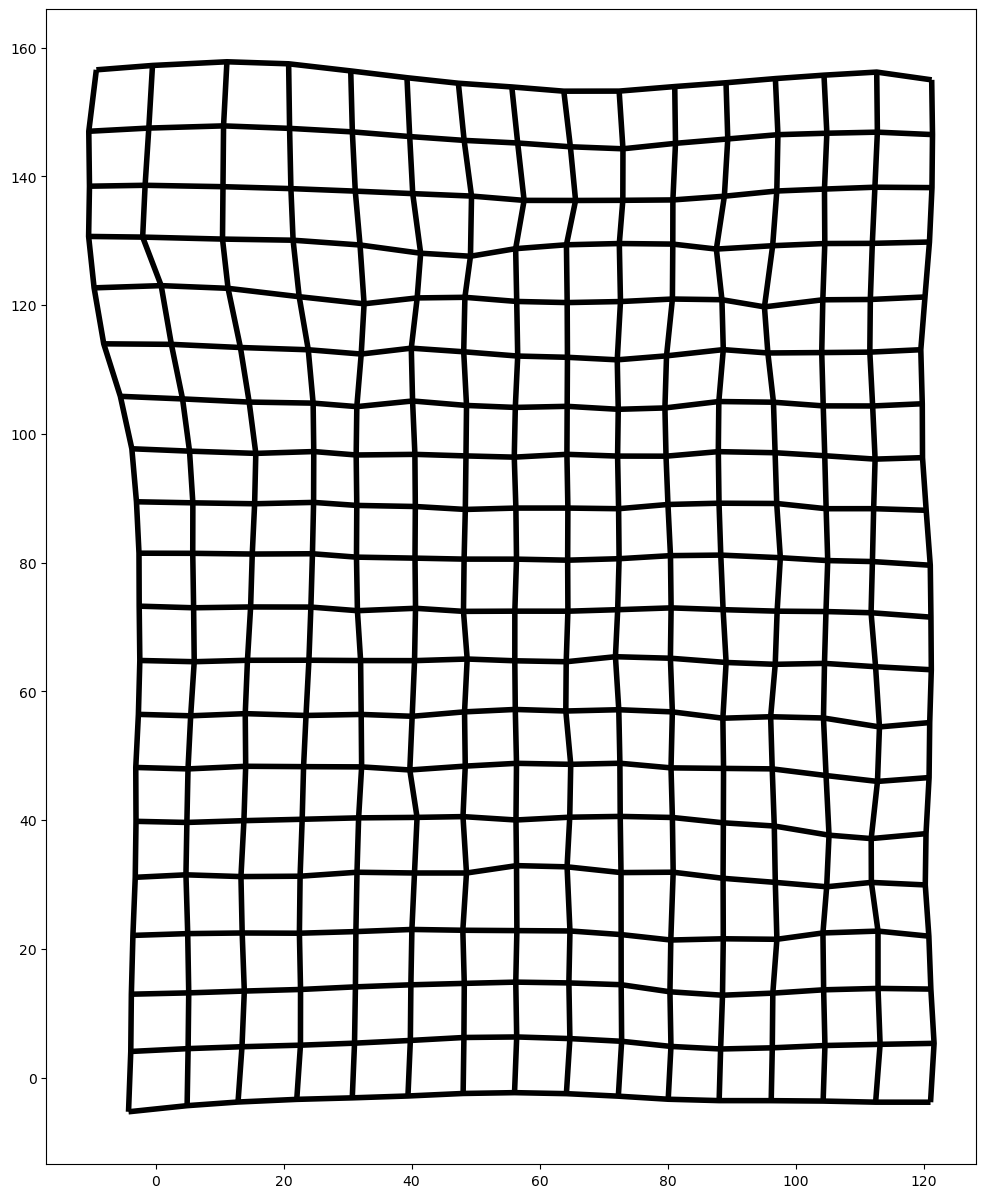

In [14]:
plt.style.use('default')
def plot_flow(flow, z, spacing=8, ax=None):
    def plot_grid(x,y, ax=ax, **kwargs):
        ax = ax or plt.gca()
        segs1 = np.stack((x,y), axis=2)
        segs2 = segs1.transpose(1,0,2)
        ax.add_collection(LineCollection(segs1, **kwargs))
        ax.add_collection(LineCollection(segs2, **kwargs))
        ax.autoscale()

    grid_x,grid_y = np.meshgrid(np.linspace(0, flow.shape[1], flow.shape[1]), np.linspace(0, flow.shape[0], flow.shape[0]))
#     plot_grid(grid_x[::spacing, ::spacing],grid_y[::spacing, ::spacing], ax=ax,  color="lightgrey")

    distx = grid_x[::spacing, ::spacing] - flow[::spacing, ::spacing, z, 1]
    disty = grid_y[::spacing, ::spacing] - flow[::spacing, ::spacing, z, 0]
    # distx, disty = f(grid_x,grid_y)
    plot_grid(disty, distx, ax=ax, color="black", linewidths=4)
    
fig, ax = plt.subplots(figsize=(12,15))
plot_flow(flow[0].squeeze().numpy().transpose((1,2,3,0)), spacing=8, z=100, ax=ax)

In [16]:
flow[0].shape

torch.Size([1, 3, 128, 160, 128])